# Notebook for analyzing Insider tradings and the effects on stock prices
Written by Thomas Niedermayer and Gunnar Sjúrðarson Knudsen, as a conjoined effort for an interdiscplinary project in Data Science.

Supervisor: Wolfgang Aussenegg

Co-Supervisor: Sascha Hunold

Purpose of this notebook is XXX

## Remaining todos:

* T1_ vs T1!!!
* A lot!
* Figure out which custom functions we are still using
  - * How much would Thomas hate me, if I moved "Main" to a notebook as well?
* Figure out if different hypotheses should be tested based on "NAME" - or do both do all analysis?
* Refactor - we have data locations in two different varialbes (CAPS and preceeding underscore)
* I MIGHT have deleted too much from data_checks.run
* main.py: check which imports are used
* Currently have two different datasets for the ReturnIndex data - with (linear) interpolation, as well as skipping rows that don't exist in market and company.
* Figure out what to do, when event date not in the dataset. Could still "just" do closest possible, provided that trades occur around the date.
* Rerun main.py for Niedermayer - needs the re-processed dataset with market information!
* What do we do when tickers are non-unique!? I think this is a nasty that breaks more than we know
* document get_all_directors_dealings_async
* document analyse_single_company
* Are outliers "Significant"? Wilcoxon compared to t-test

#### Ask Prof. Aussenegg
* How to compare before and after pandemic? subsample to get the same sample size and 2 sample ttest?
* Is it fair to compare like before pandemic with during pandemic? when there is an estimation window in the pre pandemic time and the event window is in the pandemic time
* Are we allowed to persist and upload the preprocessed data for this study?

### Hypotheses

#### Gunnar

1. Hypothesis 1: Insiders are able to earn significant abnormal returns in the first
weeks after disclosure.
2. Hypothesis 2: Trades of type “Purchase” are most explaining of abnormal return.
“Sale” less so, and “Sale + Option” does not have an effect.
3. Hypothesis 3: Directors have changed behaviour during the times of Covid.

#### Tom

1. Hypothesis 1: Insiders are able to earn significant abnormal returns in
the first weeks after disclosure of relevant information.
2. Hypothesis 2: Insiders are significantly good at avoiding risk indicated
by market downturns after insiders selling shares.
3. Hypothesis 3: Directors have changed behaviour during the times of
covid: Hypotheses 1 and 2 can be answered with significantly different
confidence before and during the pandemic.



## Setup

### Define which analysis is run
Add a name here. This affects which data is read in, as well as which analysis are done?

In [66]:
NAME = "Niedermayer" # "Niedermayer"

### Load Libraries

In [67]:
# Standard libraries
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
from tqdm import tqdm
from scipy import stats


# custom functions
import source.analyse_single_company as UASC
from source import data_checks, determine_T0_T1_T2, cut_timeseries, calculate_coefficients
import logging

logging.getLogger().setLevel(logging.WARNING)

#plt.style.use("seaborn")

### Read in the data

In [68]:
# Data locations
DATA_LOCATION = f'data/{NAME}/'
DATA_LOCATION_INSIDER_PROCESSED = DATA_LOCATION + 'processed/insider/'
DATA_LOCATION_RI = DATA_LOCATION + 'processed/RI_discard/'

investigation_periods = {
    "overall": (pd.Timestamp("2018-01-01"), pd.Timestamp("2021-12-31")),
    "pre-pandemic": (pd.Timestamp("2018-01-01"), pd.Timestamp("2020-02-29")),
    "pandemic": (pd.Timestamp("2020-03-01"), pd.Timestamp("2021-12-31")),
}


# Read in the summary data from "CompaniesToExclude" notebook
summary_data = pd.read_csv(DATA_LOCATION + '/scraping_summary.csv', index_col=0)
# Generate list of which companies to analyse
isins_to_use = summary_data[summary_data['reason_to_exclude'] == 'None']['ISIN CODE'].to_list()
display(summary_data)
print(f'We want to reduce to {len(isins_to_use)} isins')


## Not sure why we do this - maybe refactor
_ri_location = DATA_LOCATION_RI
_insider_location = DATA_LOCATION_INSIDER_PROCESSED

# Get locations to read in
file_locs_ = os.listdir(_ri_location)
print(f'Found {len(file_locs_)} possible files to analyze')
# Filter files for analysis, and append path:
file_locs = [_ri_location + f for f in file_locs_ if f[:-7] in isins_to_use]
print(f'We are left with {len(file_locs)} to analyze')

# Actually read in the company information
companies = []
print("loading return series...")
for file_loc in tqdm(file_locs):
    with open(file_loc, "rb") as f:
        company = pickle.load(f)
    companies.append(company)

,ISIN CODE,NAME,TICKER SYMBOL,trade_count,n_distinct_traders,n_distinct_trade_types,ts_rows,reason_to_exclude
764,US35953D1046,FUBOTV,FUBO,40,8,7,1509.0,Faulty timeseries data
954,US46124J2015,INVENTRUST PROPERTIES,IVT,4,4,1,1509.0,Faulty timeseries data
1939,NaN,ABOVENET 'B',ABVT,179,21,10,824.0,Missing ISIN
2093,NaN,ATHENA CONSUMER ACQUISITION CL B,ACAQ,1,1,1,824.0,Missing ISIN
2062,NaN,ARCTIC CAT 'B' DEAD - 07/03/17,ACAT,446,33,8,824.0,Missing ISIN
...,...,...,...,...,...,...,...,...
1057,US53228T1016,LIGHTNING EMOTORS,ZEV,16,13,5,430.0,None
3636,US98979J1097,ZOES KITCHEN DEAD - DELIST.21/11/18,ZOES,87,17,8,675.0,None
1923,US98978V1035,ZOETIS A,ZTS,499,34,8,1509.0,None
1926,US98983L1089,ZURN WATER SOLUTIONS,ZWS,526,27,8,1509.0,None


We want to reduce to 1534 isins
Found 2171 possible files to analyze
We are left with 1534 to analyze
loading return series...


100%|██████████| 1534/1534 [00:02<00:00, 658.50it/s]


## Exploratory Data Analysis

### Calculate Returns, Analyse Companies

In [69]:
print("Returns")
returns_df = [c.return_index_df.company_return for c in companies]

print("concatenate")
df_returns = pd.concat(returns_df, axis=1)
df_return_index = pd.concat([c.return_index_df for c in companies], axis=1)

print("get filing lags ...")

lags = []
for company in tqdm(companies):
    lag = UASC.analyse_single_company(company)
    lags.append(lag)

Returns
concatenate
get filing lags ...


100%|██████████| 1534/1534 [02:19<00:00, 10.99it/s]


### Visualise Mean Daily Returns

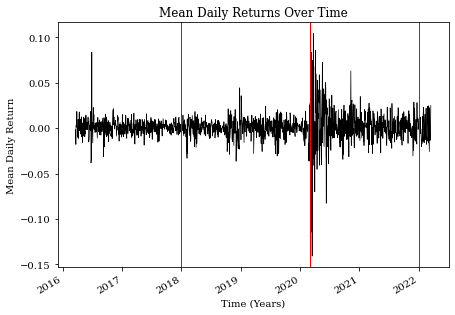

In [70]:
plt.rc('font', family='serif')
plt.rc('xtick')
plt.rc('ytick')

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)

returns_companies = df_returns.mean(axis=1)
returns_companies.plot(color="k", linewidth=0.7)

ax.set_xlabel('Time (Years)')
ax.set_ylabel('Mean Daily Return')
ax.set_title('Mean Daily Returns Over Time')

interval_borders = ["2018-01-01", "2020-03-01", "2021-12-31"] # TODO see if it makes sense to actually take first of Feb

for int_ in interval_borders:
    plt.axvline(x = int_, color = 'red', label = 'DD Event time', linewidth = 1)

plt.savefig(DATA_LOCATION +"visualisations/NYSE_daily_returns.jpg", dpi=600)
plt.show()


### Investigate Filing Trade Lag Times

Negative lag for 153 out of 1098006 trades.
Lag longer than 21 days for 27344 out of 1098006 trades.
Eligible trades: 1070509 out of 1098006 trades.


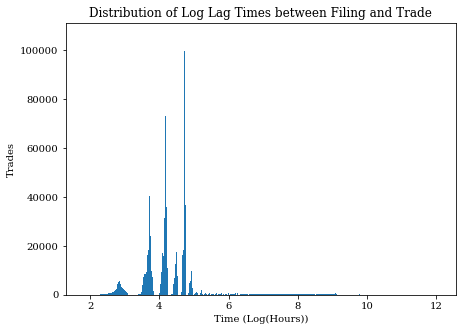

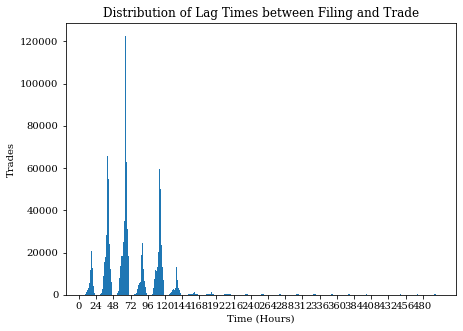

In [71]:
filing_trade_lags = sum(lags, [])

lag_in_hours = np.asarray(filing_trade_lags)
negative_lag_mask = lag_in_hours < 0
positive_lag = lag_in_hours[~negative_lag_mask]
in_21_days = positive_lag < 21*24
relevant_lag = positive_lag[in_21_days]
print(f"Negative lag for {negative_lag_mask.sum()} out of {len(negative_lag_mask)} trades.")
print(f"Lag longer than 21 days for {len(positive_lag) - len(relevant_lag)} out of {len(negative_lag_mask)} trades.")
print(f"Eligible trades: {len(relevant_lag)} out of {len(negative_lag_mask)} trades.")

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)
plt.hist(np.log(positive_lag), bins="auto")
ax.set_xlabel('Time (Log(Hours))')
ax.set_ylabel('Trades')
ax.set_title('Distribution of Log Lag Times between Filing and Trade')

plt.savefig(DATA_LOCATION +"visualisations/log_transformed_lags.jpg", dpi=600)
plt.show()

without_outliers = positive_lag[positive_lag < 24*21]

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)
plt.hist(without_outliers, bins="auto")
plt.xticks(np.arange(0, max(without_outliers) + 1, 24))
ax.set_xlabel('Time (Hours)')
ax.set_ylabel('Trades')
ax.set_title('Distribution of Lag Times between Filing and Trade')

plt.savefig(DATA_LOCATION +"visualisations/lags_without_outliers.jpg", dpi=600)

### Drop companies with lags longer than 21 days or negative lags

In [72]:
for lags_c, company in tqdm(zip(lags, companies)):
    lags_c = np.asarray(lags_c)
    mask_eligible = (lags_c >= 0) | (lags_c <= 21*24)
    company.insider_data_df = company.insider_data_df[mask_eligible]

1534it [00:00, 2539.74it/s]


### Remove companies outside of the timeframe of interest

In [73]:
# this is the interval where filings are interesting to us
earliest_timestamp = list(investigation_periods.values())[0][0]
latest_timestamp = list(investigation_periods.values())[-1][1]
filings_removed = 0
filings_total = 0

for company in tqdm(companies):
    insider_data_df = company.insider_data_df
    filing_dates = insider_data_df.FilingDate.apply(lambda x: x.floor("d"))
    mask = (filing_dates >= earliest_timestamp) & (filing_dates <= latest_timestamp)
    company.insider_data_df = company.insider_data_df[mask]
    filings_removed += (~mask).sum()
    filings_total += mask.shape[0]

print("Total filings: {}".format(filings_total))
print("Removed {} filings".format(filings_removed))
print("Remaining filings: {}".format(filings_total - filings_removed))

100%|██████████| 1534/1534 [00:24<00:00, 61.42it/s]

Total filings: 1098006
Removed 807342 filings
Remaining filings: 290664


## Demonstrate process for a single event

### Define windows

#### Our data contains multiple companies. A single company contains multiple filings and each filing is an event

![alt text](assets/images/windows.png "Title")

In [74]:
## Constants defining how long both Estimation Window and Event Window are
### Probably also input parameters to a function call, as we need loops later...
L1_length = 100
L2_length = 40 # TODO +-20 days = 40 days, right?

### Fix a company

In [75]:
logging.getLogger().setLevel(logging.DEBUG)

if NAME == "Knudsen":
    company_index = -87
elif NAME == "Niedermayer":
    company_index = -11
else:
    raise NotImplementedError
company = companies[company_index]
print(company)
company_return = company.return_index_df

Company(company_type='2634JX', isin='US98850P1093', name='YUM CHINA HOLDINGS', ticker='YUMC', start_date=Timestamp('2016-10-17 00:00:00'), end_date=datetime.datetime(2022, 3, 16, 0, 0), return_index_df=            ReturnIndex  company_return  market_return
Date                                                  
2016-10-17       100.00             NaN            NaN
2016-10-18        95.28       -0.047200       0.007143
2016-10-19        94.58       -0.007347       0.003133
2016-10-20        94.54       -0.000423      -0.000336
2016-10-21        97.15        0.027607      -0.002404
...                 ...             ...            ...
2022-03-10       180.06       -0.109407      -0.003003
2022-03-11       152.13       -0.155115      -0.011040
2022-03-14       148.36       -0.024781      -0.003767
2022-03-15       160.62        0.082637       0.012828
2022-03-16       175.84        0.094758       0.023014

[1363 rows x 3 columns], insider_data_df=     X          FilingDate  TradeDate Tic

### Fix an event

In [76]:
# This date will be moved to a loop
## Define which periods we are looking at.

if NAME == "Knudsen":
    event_index = 60
elif NAME == "Niedermayer":
    event_index = -200
else:
    raise NotImplementedError
    
event_timestamp = company.insider_data_df.FilingDate.iloc[event_index].floor("d")
print("event timestamp: ", event_timestamp)

event timestamp:  2021-02-11 00:00:00


### Technical Checks

In [77]:
data_checks.run(L1_length, L2_length, event_timestamp, company_return)#, market_timeseries)

In [78]:
#company_return

### Determine T0, T1 and T2

In [79]:
T0_, T1_, T2_, T0, T1, T2, ERROR, msg = determine_T0_T1_T2.run(L1_length, L2_length, event_timestamp, company_return)#, market_timeseries)

DEBUG:root:Found T1 to be 2021-01-13 00:00:00 on index 1067
DEBUG:root:Found T2 to be 2021-03-12 00:00:00 on index 1107
DEBUG:root:Found T0 to be 2020-08-20 00:00:00 on index 967
DEBUG:root:------------------------------
DEBUG:root:Event occurred at             2021-02-11 00:00:00
DEBUG:root:Estimation Window (100 days): from 2020-08-20 00:00:00 to 2021-01-13 00:00:00
DEBUG:root:Event Window      ( 40 days): from 2021-01-13 00:00:00 to 2021-03-12 00:00:00


In [80]:
print(event_timestamp)
company_return

2021-02-11 00:00:00


,ReturnIndex,company_return,market_return
Date,,,
2016-10-17,100.00,NaN,NaN
2016-10-18,95.28,-0.047200,0.007143
2016-10-19,94.58,-0.007347,0.003133
2016-10-20,94.54,-0.000423,-0.000336
2016-10-21,97.15,0.027607,-0.002404
...,...,...,...
2022-03-10,180.06,-0.109407,-0.003003
2022-03-11,152.13,-0.155115,-0.011040
2022-03-14,148.36,-0.024781,-0.003767


### Abnormal and Normal Returns

![alt text](assets/images/return_estimation.png "Title")

### Cut return timeseries into correct periods

In [81]:
windows = cut_timeseries.run(company_return, T0, T1, T2)
estimation_window_market_return, estimation_window_company_return, event_window_market_return, event_window_company_return = windows

DEBUG:root:shapes (Shouldnt be an issue after better preprocessing)
DEBUG:root:# estimation_window_market_return: (100,)
DEBUG:root:# estimation_window_market_return: (100,)
DEBUG:root:# event_window_market_return: (41,)
DEBUG:root:# event_window_company_return: (41,)


### Calculate coefficients

In [82]:
alpha, beta = calculate_coefficients.run(estimation_window_market_return, estimation_window_company_return)

DEBUG:root:                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     28.31
Date:                Tue, 20 Sep 2022   Prob (F-statistic):           6.54e-07
Time:                        20:59:25   Log-Likelihood:                 283.44
No. Observations:                 100   AIC:                            -562.9
Df Residuals:                      98   BIC:                            -557.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.001     -0.2

### The Abnormal Return
This is the last step of the whole process for one event

In [83]:
company_return = event_window_company_return
market_return = event_window_market_return
estimated_return = alpha + beta*market_return
abnormal_return = company_return - estimated_return
print(abnormal_return)

Date
2021-01-13    0.005520
2021-01-14   -0.018376
2021-01-15    0.002065
2021-01-19    0.033015
2021-01-20   -0.009229
2021-01-21    0.008785
2021-01-22   -0.006243
2021-01-25   -0.004721
2021-01-26    0.020355
2021-01-27   -0.002115
2021-01-28   -0.026937
2021-01-29    0.008670
2021-02-01    0.009054
2021-02-02    0.004114
2021-02-03   -0.023990
2021-02-04   -0.029093
2021-02-05    0.020921
2021-02-08    0.032259
2021-02-09    0.022988
2021-02-10   -0.010210
2021-02-11    0.019935
2021-02-12    0.010480
2021-02-16    0.025953
2021-02-17   -0.001255
2021-02-18   -0.007922
2021-02-19   -0.014811
2021-02-22   -0.015449
2021-02-23   -0.022933
2021-02-24   -0.004807
2021-02-25    0.013430
2021-02-26    0.004602
2021-03-01   -0.015240
2021-03-02   -0.004020
2021-03-03    0.009235
2021-03-04    0.004855
2021-03-05    0.006890
2021-03-08    0.007714
2021-03-09    0.004735
2021-03-10   -0.020458
2021-03-11    0.011022
2021-03-12   -0.010399
dtype: float64


<AxesSubplot:xlabel='Date'>

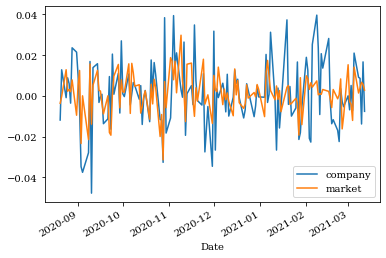

In [84]:
company_and_estimated = pd.DataFrame({"company":event_window_company_return, "market":estimated_return})
company_and_market = pd.DataFrame({"company": estimation_window_company_return, "market":estimation_window_market_return})
df_to_plot = pd.concat([company_and_market, company_and_estimated])
df_to_plot.plot()

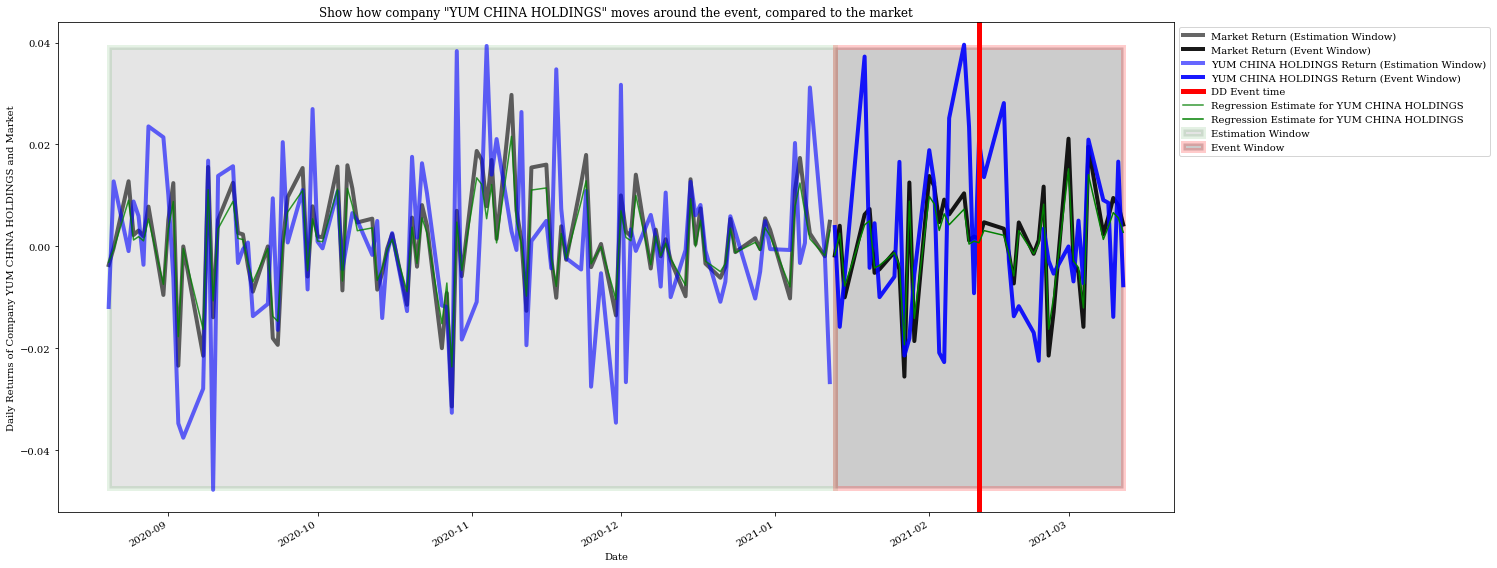

I'm impressed! It looks like a five-year-old drew this plot in paint


In [85]:
Company_name = company.name

# Estimations
est_estimation = estimation_window_market_return * beta + alpha
est_event = event_window_market_return * beta + alpha

plt.figure(figsize=(20,10))
estimation_window_market_return.plot(color = 'black', alpha = 0.6, linewidth=4, label = 'Market Return (Estimation Window)')
event_window_market_return.plot(color = 'black', alpha = 0.9, linewidth=4, label = 'Market Return (Event Window)')

estimation_window_company_return.plot(color = 'blue', alpha = 0.6, linewidth = 4, label = f'{Company_name} Return (Estimation Window)')
event_window_company_return.plot(color = 'blue', alpha = 0.9, linewidth = 4, label = f'{Company_name} Return (Event Window)')

plt.axvline(x = event_timestamp, color = 'red', label = 'DD Event time', linewidth = 5)
plt.ylabel(f'Daily Returns of Company {Company_name} and Market')
est_estimation.plot(color = 'green', label = f'Regression Estimate for {Company_name}', alpha = 0.8)
est_event.plot(color = 'green', label = f'Regression Estimate for {Company_name}', alpha = 1)

plt.axvspan(T0, T1, ymin = 0.05, ymax = 0.95, facecolor='black', alpha=0.1, label = 'Estimation Window', edgecolor='g', linewidth=5)
plt.axvspan(T1, T2, ymin = 0.05, ymax = 0.95, facecolor='black', alpha=0.2, label = 'Event Window', edgecolor='r', linewidth=5)
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')

plt.title(f'Show how company "{Company_name}" moves around the event, compared to the market')
plt.show()
print("I'm impressed! It looks like a five-year-old drew this plot in paint")


In [86]:
EVENT_INDEX = 20 # because 20 [0,..19] are before the event

## Macro Analysis

### Now that we have seen the process for one single filing, let us do the same for all filings in all companies


In [87]:
# Initialize testing
logging.getLogger().setLevel(logging.ERROR)

# Helpers
multiind, data, data_errors = [], [], []
n_companies = len(companies)


#for j in tqdm(range(len(companies[:200]))):
for j in tqdm(range(len(companies))):
    # Get information from said company
    company = companies[j]
    company_return = company.return_index_df
    
    n_filings = len(company.insider_data_df)
    # Go through all filings
    for i in company.insider_data_df.FilingDate.index:

        # TODO probably not used anymore
        # Find our event date from filing
        filing_date = company.insider_data_df.FilingDate[i]
        event_timestamp = filing_date.floor("d")

        # TODO probably not used anymore
        # if the timestamp is too early or too late we skip
        if event_timestamp < earliest_timestamp or event_timestamp > latest_timestamp:
            #print("skipping, filing is too early or too late")
            continue
            
        #print(f"working on company {j}/{n_companies} named {company.name}, filing {i}/{n_filings}")

        # do the process for one filing
        ## See if it's possible
        checks = data_checks.run(L1_length, L2_length, event_timestamp, company_return)
        if checks:
            #print(checks[1])
            data_errors.append(checks[0])
            continue
   
        ## Proceed to find periods
        T0_, T1_, T2_, T0, T1, T2, ERRORS, msg = determine_T0_T1_T2.run(L1_length, L2_length, event_timestamp, company_return)
        if ERRORS:
            #print(msg)
            data_errors.append(ERRORS)
            continue
            
        ## Cut timeseries to the relevant periods, and split them
        windows = cut_timeseries.run(company_return, T0, T1, T2)
        estimation_window_market_return, estimation_window_company_return, event_window_market_return, event_window_company_return = windows
        alpha, beta = calculate_coefficients.run(estimation_window_market_return, estimation_window_company_return)

        ## Calculate the abnormal returns
        abnormal_return = event_window_company_return - alpha - beta*event_window_market_return
        
        ## Append to results set
        multiind.append((company.ticker, i, company.insider_data_df.TradeType[i], event_timestamp))
        data.append(abnormal_return)

 22%|██▏       | 333/1534 [04:23<15:51,  1.26it/s] 


KeyboardInterrupt: 

In [88]:
# process abnormal returns
df_abnormal_returns = pd.DataFrame.from_records([d.reset_index(drop=True) for d in data])
df_abnormal_returns.index = pd.MultiIndex.from_tuples(multiind, names=["Company", "i", "TradeType", "event_timestamp"])
df_abnormal_returns

0         1         2   \
Company i   TradeType   event_timestamp                                 
SLB     59  A - Grant   2021-12-21       0.014488  0.020009  0.004322   
        60  A - Grant   2021-12-21       0.014488  0.020009  0.004322   
        61  S - Sale    2021-12-09      -0.028087 -0.001870 -0.010602   
        62  F - Tax     2021-12-03       0.011502  0.001633  0.015117   
        63  M - OptEx   2021-12-03       0.011502  0.001633  0.015117   
...                                           ...       ...       ...   
BR      147 M - OptEx   2021-02-19      -0.004113 -0.009936  0.012903   
        148 S - Sale+OE 2021-02-19      -0.004113 -0.009936  0.012903   
        149 G - Gift    2021-02-17      -0.005557 -0.000341 -0.004155   
        150 M - OptEx   2021-02-12      -0.007768 -0.003790 -0.005629   
        151 S - Sale+OE 2021-02-12      -0.007768 -0.003790 -0.005629   

                                               3         4         5   \
Company i   TradeType   event_timestamp                                 
SLB     59  A - Grant   2021-12-21       0.003310 -0.009099  0.023843   
        60  A - Grant   2021-12-21       0.003310 -0.009099  0.023843   
        61  S - Sale    2021-12-09       0.000851  0.003322 -0.009983   
        62  F - Tax     2021-12-03      -0.000682 -0.027669 -0.001546   
        63  M - OptEx   2021-12-03      -0.000682 -0.027669 -0.001546   
...                                           ...       ...       ...   
BR      147 M - OptEx   2021-02-19       0.011859 -0.030231 -0.002785   
        148 S - Sale+OE 2021-02-19       0.011859 -0.030231 -0.002785   
        149 G - Gift    2021-02-17      -0.009980  0.012849  0.011815   
        150 M - OptEx   2021-02-12      -0.000411 -0.004253 -0.010077   
        151 S - Sale+OE 2021-02-12      -0.000411 -0.004253 -0.010077   

                                               6         7         8   \
Company i   TradeType   event_timestamp                                 
SLB     59  A - Grant   2021-12-21       0.017127 -0.015654  0.016375   
        60  A - Grant   2021-12-21       0.017127 -0.015654  0.016375   
        61  S - Sale    2021-12-09       0.004347 -0.036822  0.013957   
        62  F - Tax     2021-12-03      -0.010316  0.001206  0.003654   
        63  M - OptEx   2021-12-03      -0.010316  0.001206  0.003654   
...                                           ...       ...       ...   
BR      147 M - OptEx   2021-02-19      -0.007126  0.021396 -0.007536   
        148 S - Sale+OE 2021-02-19      -0.007126  0.021396 -0.007536   
        149 G - Gift    2021-02-17      -0.030215 -0.002878 -0.007130   
        150 M - OptEx   2021-02-12       0.012760  0.011718 -0.030359   
        151 S - Sale+OE 2021-02-12       0.012760  0.011718 -0.030359   

                                               9   ...        31        32  \
Company i   TradeType   event_timestamp            ...                       
SLB     59  A - Grant   2021-12-21      -0.007811  ...  0.018661  0.028383   
        60  A - Grant   2021-12-21      -0.007811  ...  0.018661  0.028383   
        61  S - Sale    2021-12-09       0.019600  ... -0.014792  0.010434   
        62  F - Tax     2021-12-03      -0.009554  ...  0.015301 -0.007760   
        63  M - OptEx   2021-12-03      -0.009554  ...  0.015301 -0.007760   
...                                           ...  ...       ...       ...   
BR      147 M - OptEx   2021-02-19      -0.017366  ... -0.006522 -0.003789   
        148 S - Sale+OE 2021-02-19      -0.017366  ... -0.006522 -0.003789   
        149 G - Gift    2021-02-17       0.021299  ... -0.004530  0.006147   
        150 M - OptEx   2021-02-12      -0.002935  ... -0.014863 -0.008780   
        151 S - Sale+OE 2021-02-12      -0.002935  ... -0.014863 -0.008780   

                                               33        34        35  \
Company i   TradeType   event_timestamp                                 
SLB     59  A - Grant   2021-12-21  

### Show the reasons filings were dropped

<AxesSubplot:>

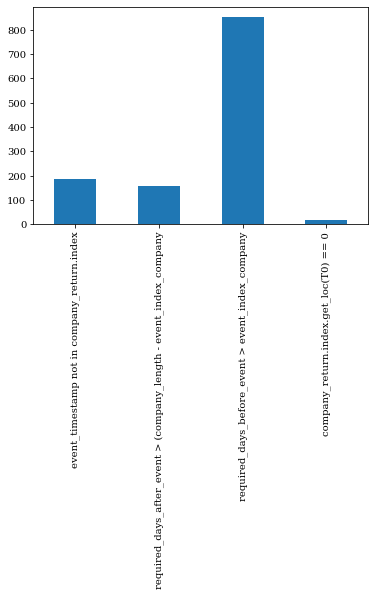

In [89]:
errors_df = pd.DataFrame.from_records(data_errors)
errors_df.sum(axis=0).plot.bar()

### Having a look at all trade types together

In [125]:
types_of_interest = ["P - Purchase", "S - Sale", "S - Sale+OE"]
df_abnormal_returns.loc[:,:,types_of_interest,:]

0         1         2   \
Company i   TradeType    event_timestamp                                 
SLB     162 P - Purchase 2020-09-15      -0.006425 -0.006966  0.006025   
        163 P - Purchase 2020-08-06      -0.028556  0.021393 -0.012399   
        203 P - Purchase 2020-04-01      -0.047837  0.005169 -0.045674   
        204 P - Purchase 2020-03-10      -0.006840  0.005789  0.013451   
        205 P - Purchase 2020-02-05       0.000940 -0.035174  0.001796   
...                                            ...       ...       ...   
BR      100 S - Sale+OE  2021-08-04       0.019774 -0.001259 -0.000878   
        102 S - Sale+OE  2021-08-02       0.006718  0.007375  0.019860   
        104 S - Sale+OE  2021-07-15      -0.001955  0.004743  0.007275   
        148 S - Sale+OE  2021-02-19      -0.004113 -0.009936  0.012903   
        151 S - Sale+OE  2021-02-12      -0.007768 -0.003790 -0.005629   

                                                3         4         5   \
Company i   TradeType    event_timestamp                                 
SLB     162 P - Purchase 2020-09-15      -0.040080 -0.008219  0.030018   
        163 P - Purchase 2020-08-06       0.060691 -0.019859  0.003671   
        203 P - Purchase 2020-04-01      -0.138943 -0.017392  0.038622   
        204 P - Purchase 2020-03-10      -0.003797 -0.004870 -0.012655   
        205 P - Purchase 2020-02-05       0.004768 -0.027833  0.008152   
...                                            ...       ...       ...   
BR      100 S - Sale+OE  2021-08-04      -0.004160  0.002781  0.011421   
        102 S - Sale+OE  2021-08-02      -0.001013 -0.000984 -0.004091   
        104 S - Sale+OE  2021-07-15       0.000280 -0.000873 -0.007648   
        148 S - Sale+OE  2021-02-19       0.011859 -0.030231 -0.002785   
        151 S - Sale+OE  2021-02-12      -0.000411 -0.004253 -0.010077   

                                                6         7         8   \
Company i   TradeType    event_timestamp                                 
SLB     162 P - Purchase 2020-09-15      -0.017608 -0.035014 -0.000742   
        163 P - Purchase 2020-08-06      -0.014874 -0.005828  0.048371   
        203 P - Purchase 2020-04-01      -0.012035 -0.002455  0.079066   
        204 P - Purchase 2020-03-10       0.014845 -0.007954  0.000304   
        205 P - Purchase 2020-02-05      -0.033017 -0.001509 -0.016895   
...                                            ...       ...       ...   
BR      100 S - Sale+OE  2021-08-04       0.005005  0.001219 -0.004405   
        102 S - Sale+OE  2021-08-02       0.002951  0.011544  0.005136   
        104 S - Sale+OE  2021-07-15      -0.003050 -0.003369  0.005887   
        148 S - Sale+OE  2021-02-19      -0.007126  0.021396 -0.007536   
        151 S - Sale+OE  2021-02-12       0.012760  0.011718 -0.030359   

                                                9   ...        31        32  \
Company i   TradeType    event_timestamp            ...                       
SLB     162 P - Purchase 2020-09-15       0.025470  ... -0.015706 -0.037604   
        163 P - Purchase 2020-08-06      -0.025087  ... -0.007073  0.034318   
        203 P - Purchase 2020-04-01      -0.109329  ...  0.031486  0.024975   
        204 P - Purchase 2020-03-10      -0.013527  ... -0.058915 -0.040849   
        205 P - Purchase 2020-02-05      -0.026703  ... -0.000785 -0.009042   
...                                            ...  ...       ...       ...   
BR      100 S - Sale+OE  2021-08-04       0.000745  ...  0.005519 -0.000467   
        102 S - Sale+OE  2021-08-02       0.001417  ...  0.004603 -0.010636   
        104 S - Sale+OE  2021-07-15       0.009431  ...  0.011601  0.001134   
        148 S - Sale+OE  2021-02-19      -0.017366  ... -0.006522 -0.003789   
        151 S - Sale+OE  2021-02-12      -0.002935  ... -0.014863 -0.008780   

                                                33        34        35  \
Company i   TradeType    event_timestamp                 

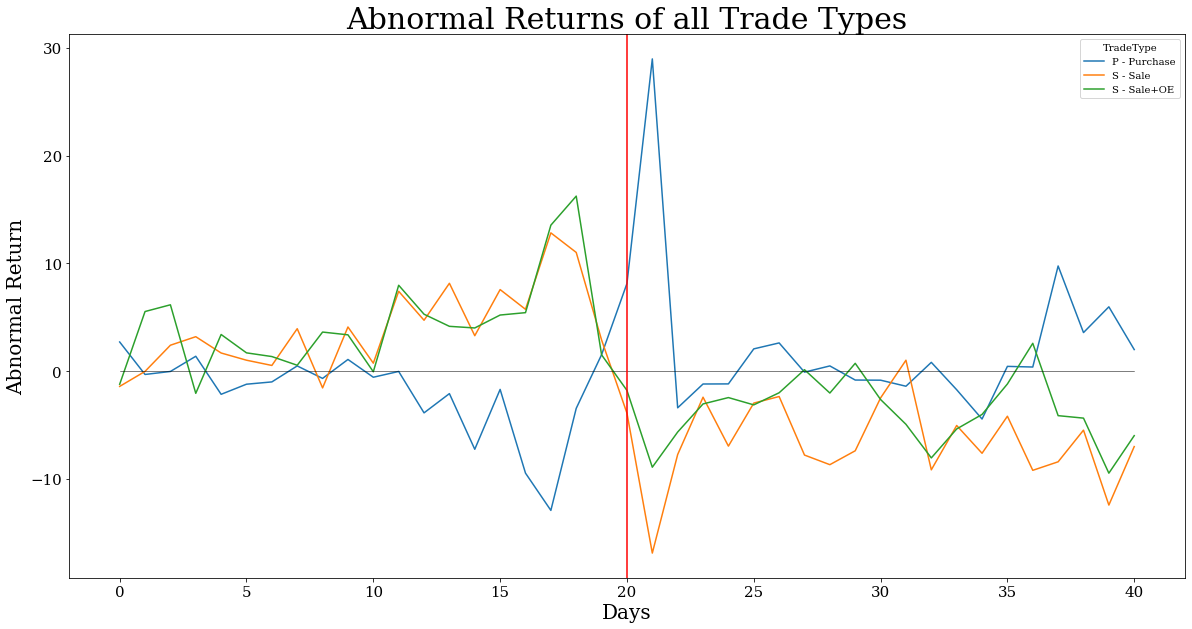

In [91]:

a = df_abnormal_returns.loc[:,:,types_of_interest,:].groupby(level=[2]).sum().transpose().plot(figsize=(20, 10), fontsize=15)
plt.plot(np.zeros(len(df_abnormal_returns.columns)), color="black", linewidth=0.5)
a.set_title("Abnormal Returns of all Trade Types",fontsize=30)
a.set_xlabel("Days", fontsize=20)
a.set_ylabel("Abnormal Return", fontsize=20)
plt.axvline(x = EVENT_INDEX, color = 'red', label = 'DD Event time', linewidth = 1.5)
plt.savefig(f"data/{NAME}/visualisations/AR_selected_tradetypes.png", dpi=600)

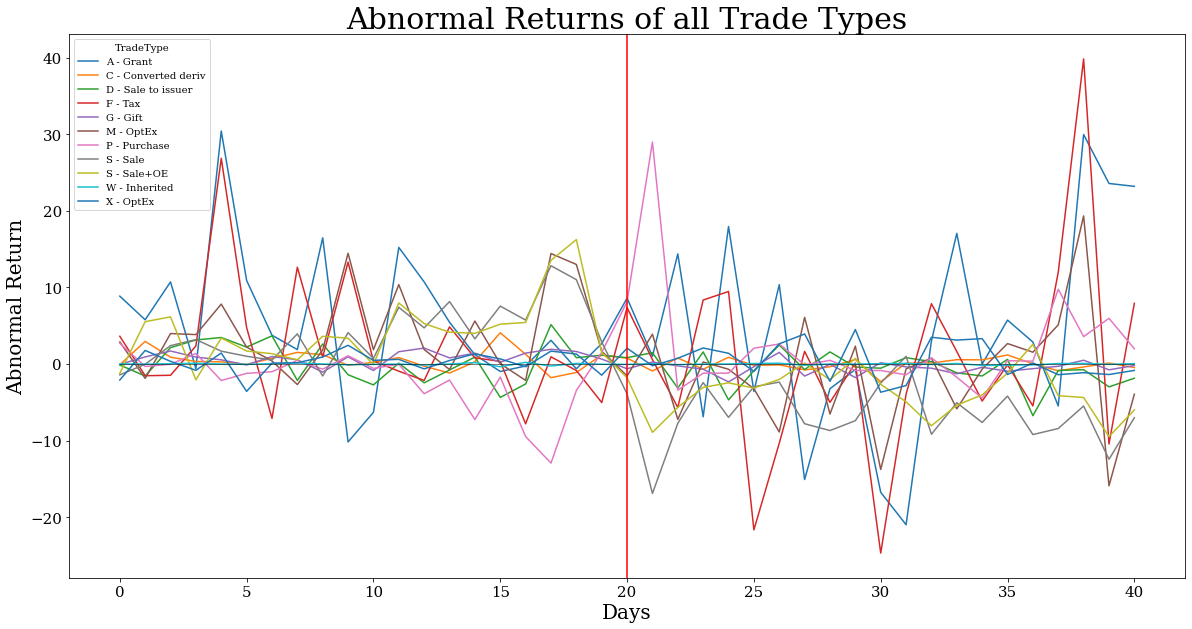

In [92]:
a = df_abnormal_returns.groupby(level=[2]).sum().transpose().plot(figsize=(20, 10), fontsize=15)
plt.plot(np.zeros(len(df_abnormal_returns.columns)), color="black", linewidth=0.5)
a.set_title("Abnormal Returns of all Trade Types",fontsize=30)
a.set_xlabel("Days", fontsize=20)
a.set_ylabel("Abnormal Return", fontsize=20)
plt.axvline(x = EVENT_INDEX, color = 'red', label = 'DD Event time', linewidth = 1.5)
plt.savefig(f"data/{NAME}/visualisations/AR_all_tradetypes.png", dpi=600)

In [93]:
df_abnormal_returns

0         1         2   \
Company i   TradeType   event_timestamp                                 
SLB     59  A - Grant   2021-12-21       0.014488  0.020009  0.004322   
        60  A - Grant   2021-12-21       0.014488  0.020009  0.004322   
        61  S - Sale    2021-12-09      -0.028087 -0.001870 -0.010602   
        62  F - Tax     2021-12-03       0.011502  0.001633  0.015117   
        63  M - OptEx   2021-12-03       0.011502  0.001633  0.015117   
...                                           ...       ...       ...   
BR      147 M - OptEx   2021-02-19      -0.004113 -0.009936  0.012903   
        148 S - Sale+OE 2021-02-19      -0.004113 -0.009936  0.012903   
        149 G - Gift    2021-02-17      -0.005557 -0.000341 -0.004155   
        150 M - OptEx   2021-02-12      -0.007768 -0.003790 -0.005629   
        151 S - Sale+OE 2021-02-12      -0.007768 -0.003790 -0.005629   

                                               3         4         5   \
Company i   TradeType   event_timestamp                                 
SLB     59  A - Grant   2021-12-21       0.003310 -0.009099  0.023843   
        60  A - Grant   2021-12-21       0.003310 -0.009099  0.023843   
        61  S - Sale    2021-12-09       0.000851  0.003322 -0.009983   
        62  F - Tax     2021-12-03      -0.000682 -0.027669 -0.001546   
        63  M - OptEx   2021-12-03      -0.000682 -0.027669 -0.001546   
...                                           ...       ...       ...   
BR      147 M - OptEx   2021-02-19       0.011859 -0.030231 -0.002785   
        148 S - Sale+OE 2021-02-19       0.011859 -0.030231 -0.002785   
        149 G - Gift    2021-02-17      -0.009980  0.012849  0.011815   
        150 M - OptEx   2021-02-12      -0.000411 -0.004253 -0.010077   
        151 S - Sale+OE 2021-02-12      -0.000411 -0.004253 -0.010077   

                                               6         7         8   \
Company i   TradeType   event_timestamp                                 
SLB     59  A - Grant   2021-12-21       0.017127 -0.015654  0.016375   
        60  A - Grant   2021-12-21       0.017127 -0.015654  0.016375   
        61  S - Sale    2021-12-09       0.004347 -0.036822  0.013957   
        62  F - Tax     2021-12-03      -0.010316  0.001206  0.003654   
        63  M - OptEx   2021-12-03      -0.010316  0.001206  0.003654   
...                                           ...       ...       ...   
BR      147 M - OptEx   2021-02-19      -0.007126  0.021396 -0.007536   
        148 S - Sale+OE 2021-02-19      -0.007126  0.021396 -0.007536   
        149 G - Gift    2021-02-17      -0.030215 -0.002878 -0.007130   
        150 M - OptEx   2021-02-12       0.012760  0.011718 -0.030359   
        151 S - Sale+OE 2021-02-12       0.012760  0.011718 -0.030359   

                                               9   ...        31        32  \
Company i   TradeType   event_timestamp            ...                       
SLB     59  A - Grant   2021-12-21      -0.007811  ...  0.018661  0.028383   
        60  A - Grant   2021-12-21      -0.007811  ...  0.018661  0.028383   
        61  S - Sale    2021-12-09       0.019600  ... -0.014792  0.010434   
        62  F - Tax     2021-12-03      -0.009554  ...  0.015301 -0.007760   
        63  M - OptEx   2021-12-03      -0.009554  ...  0.015301 -0.007760   
...                                           ...  ...       ...       ...   
BR      147 M - OptEx   2021-02-19      -0.017366  ... -0.006522 -0.003789   
        148 S - Sale+OE 2021-02-19      -0.017366  ... -0.006522 -0.003789   
        149 G - Gift    2021-02-17       0.021299  ... -0.004530  0.006147   
        150 M - OptEx   2021-02-12      -0.002935  ... -0.014863 -0.008780   
        151 S - Sale+OE 2021-02-12      -0.002935  ... -0.014863 -0.008780   

                                               33        34        35  \
Company i   TradeType   event_timestamp                                 
SLB     59  A - Grant   2021-12-21  

I think OE and OptEx means option exercise. "to exercise" means to put into effect the right to buy or sell the underlying security that is specified in the options contract." Can we be sure that the action does not shift the market, and the swing in return is really due to new information? Are these trades public, so maybe they are used as a signal for traders?

### Boxplot of the sum over all companies's AR

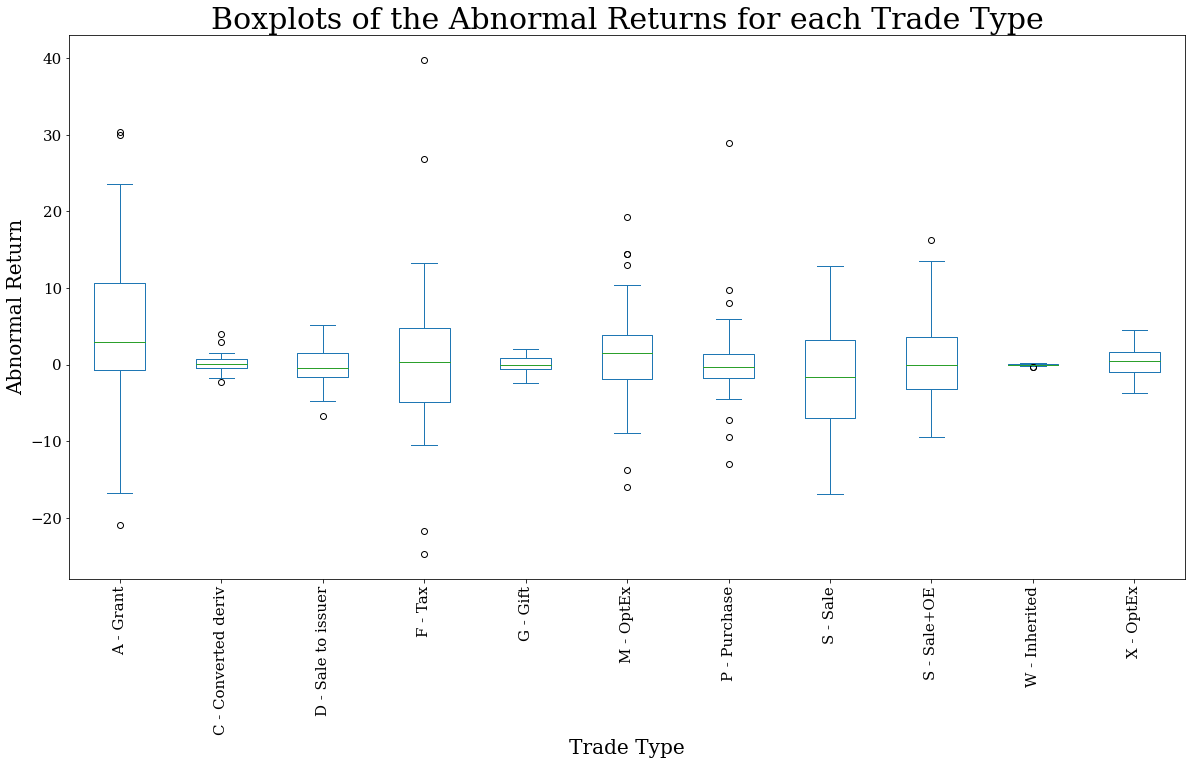

In [94]:
ax = df_abnormal_returns.groupby(level=[2]).sum().transpose().plot.box(rot=90, figsize=(20, 10), fontsize=15)
ax.set_title("Boxplots of the Abnormal Returns for each Trade Type",fontsize=30)
ax.set_xlabel("Trade Type", fontsize=20)
ax.set_ylabel("Abnormal Return", fontsize=20)

plt.savefig(f"data/{NAME}/visualisations/AR_all_tradetypes_boxplot.png", dpi=600)

![alt text](assets/images/time_agg.png)

In our case it is not company i, but filing i

Types of trade to pick from:

In [95]:
types = list(set([x[2] for x in df_abnormal_returns.index]))
types

['D - Sale to issuer',
 'P - Purchase',
 'S - Sale+OE',
 'W - Inherited',
 'M - OptEx',
 'F - Tax',
 'S - Sale',
 'A - Grant',
 'C - Converted deriv',
 'G - Gift',
 'X - OptEx']

Specify the type of the trades to investigate

In [96]:
type_ = "P - Purchase" # "S - Sale"
df_abnormal_returns_type = df_abnormal_returns.loc[:,:,type_]

The index describes the company and the index of the filing in the compnay, the columns represent the days in the event window

In [97]:
df_abnormal_returns_type

0         1         2         3         4   \
Company i   event_timestamp                                                     
SLB     162 2020-09-15      -0.006425 -0.006966  0.006025 -0.040080 -0.008219   
        163 2020-08-06      -0.028556  0.021393 -0.012399  0.060691 -0.019859   
        203 2020-04-01      -0.047837  0.005169 -0.045674 -0.138943 -0.017392   
        204 2020-03-10      -0.006840  0.005789  0.013451 -0.003797 -0.004870   
        205 2020-02-05       0.000940 -0.035174  0.001796  0.004768 -0.027833   
...                               ...       ...       ...       ...       ...   
BRX     167 2018-05-07      -0.008448 -0.007351  0.002230 -0.022535 -0.000875   
        171 2018-03-13       0.004487  0.034739  0.003704  0.007935  0.045968   
        172 2018-03-13       0.004487  0.034739  0.003704  0.007935  0.045968   
        183 2018-02-15       0.007381  0.014093 -0.000795  0.018405 -0.025568   
BR      21  2021-12-07       0.003891  0.019132  0.005850 -0.018750  0.000943   

                                   5         6         7         8         9   \
Company i   event_timestamp                                                     
SLB     162 2020-09-15       0.030018 -0.017608 -0.035014 -0.000742  0.025470   
        163 2020-08-06       0.003671 -0.014874 -0.005828  0.048371 -0.025087   
        203 2020-04-01       0.038622 -0.012035 -0.002455  0.079066 -0.109329   
        204 2020-03-10      -0.012655  0.014845 -0.007954  0.000304 -0.013527   
        205 2020-02-05       0.008152 -0.033017 -0.001509 -0.016895 -0.026703   
...                               ...       ...       ...       ...       ...   
BRX     167 2018-05-07       0.006953  0.002440 -0.010339 -0.020554 -0.007677   
        171 2018-03-13      -0.003473 -0.016333  0.011700  0.007291  0.014904   
        172 2018-03-13      -0.003473 -0.016333  0.011700  0.007291  0.014904   
        183 2018-02-15       0.001431 -0.018939  0.000358 -0.016168  0.002596   
BR      21  2021-12-07       0.002543 -0.001072 -0.010128 -0.007014  0.011774   

                             ...        31        32        33        34  \
Company i   event_timestamp  ...                                           
SLB     162 2020-09-15       ... -0.015706 -0.037604  0.035349  0.004609   
        163 2020-08-06       ... -0.007073  0.034318 -0.015851 -0.033045   
        203 2020-04-01       ...  0.031486  0.024975  0.009235  0.015305   
        204 2020-03-10       ... -0.058915 -0.040849 -0.050444 -0.077383   
        205 2020-02-05       ... -0.000785 -0.009042  0.007564 -0.017839   
...                          ...       ...       ...       ...       ...   
BRX     167 2018-05-07       ...  0.018448  0.022752 -0.001361  0.010160   
        171 2018-03-13       ...  0.048344 -0.021600  0.000757  0.005286   
        172 2018-03-13       ...  0.048344 -0.021600  0.000757  0.005286   
        183 2018-02-15       ... -0.007064  0.006199  0.012478 -0.005761   
BR      21  2021-12-07       ...  0.017960  0.001437  0.015340 -0.003142   

                                   35        36        37        38        39  \
Company i   event_timestamp                                                     
SLB     162 2020-09-15      -0.007635 -0.010095  0.010523 -0.019471 -0.015459   
        163 2020-08-06       0.000960  0.028571 -0.003306 -0.019191 -0.009802   
        203 2020-04-01       0.076558 -0.038625 -0.038239 -0.000640  0.086175   
        204 2020-03-10       0.041312  0.016864  0.064009  0.064826 -0.019252   
        205 2020-02-05       0.024086  0.036242 -0.048656  0.010125 -0.066775   
...                               ...       ...       ...       ...       ...   
BRX     167 2018-05-07       0.023301  0.009642  0.019727 -0.009647  0.007186   
        171 2018-03-13       0.028370 -0.011148  0.001297 -0.006941 -0.005927   
        172 2018-03-13       0.028370 -0.011148  0.001297 -0.006941 -0.005927   
        183 2018-02-15      -0.023740  0.010914

In [98]:
# TODO Infinity Values idk why, should check out why they are there upstream

In [99]:
mask = (-df_abnormal_returns_type == np.Inf) |(df_abnormal_returns_type == np.Inf)
print(mask.sum().sum())
df_abnormal_returns_type[mask] = 0

0


C:\Users\Tom\AppData\Local\Temp\ipykernel_17092\1661067007.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_abnormal_returns_type[mask] = 0
C:\Users\Tom\AppData\Local\Temp\ipykernel_17092\1661067007.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_abnormal_returns_type[mask] = 0


<AxesSubplot:xlabel='Company,i,event_timestamp'>

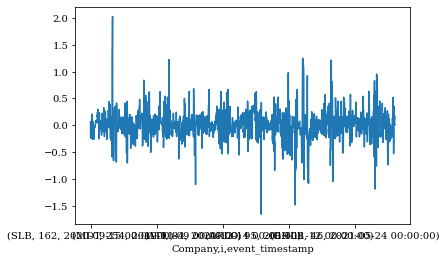

In [100]:
CAR = df_abnormal_returns_type.sum(axis=1)
CAR.plot()

![alt text](assets/images/cross_sectional_agg.png)


<AxesSubplot:>

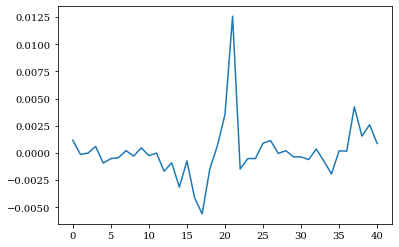

In [101]:
AR_bar = df_abnormal_returns_type.mean(axis=0) 
AR_bar.plot()

In [102]:
CAR_bar = AR_bar.sum()
CAR_bar

0.004391640303429802

In [103]:
# TODO var_CAR_bar = Does the definition make sense? It seems like we take the var of a scalar

![alt text](assets/images/cross_sectional_agg2.png)


In [104]:
CAR_bar_2 = CAR.mean()
CAR_bar_2

0.004391640303429803

In [105]:
# var car TODO not sure what just sigma means.

## Statistics

Check if CAR mean = 0 (t-test)

In [106]:

tt = stats.ttest_1samp(CAR, popmean=0)
tt

Ttest_1sampResult(statistic=0.7785427654414885, pvalue=0.43632912194770546)

Check if CAR median = 0 (wilcoxon signed rank test)

In [107]:
stats.wilcoxon(CAR)

WilcoxonResult(statistic=1316132.0, pvalue=0.7446190825041679)

In [108]:
types = types
investigation_periods = investigation_periods
multiind_p, data_p = [], []

event_day_ranges = {
    "before": (0,20), # TODO for now we drop the filing day itself
    "after": (21,41)
}


for type_ in types:
    for per in investigation_periods.keys():
        for side in event_day_ranges.keys():
                
            event_day_range = event_day_ranges[side]
            df_abnormal_returns_type = df_abnormal_returns.loc[:,:,type_]
            per_left,per_right = investigation_periods[per]


            timestamps = df_abnormal_returns_type.index.get_level_values(2)
            mask = (timestamps >= per_left) & (timestamps <= per_right)
            df_AR_type_per = df_abnormal_returns_type[mask]
            if not len(df_AR_type_per):
                print(f"skipping iteration because of 0 datapoints {(type_, per, side)}")
                continue
            df_AR_type_per_side = df_AR_type_per.iloc[:,event_day_range[0]:event_day_range[1]]
            CAR = df_AR_type_per_side.sum(axis=1)

            pvalue_ttest = round(stats.ttest_1samp(CAR, popmean=0).pvalue, 10)
            pvalue_wilcoxon = round(stats.wilcoxon(CAR).pvalue, 10)
            mean = CAR.mean()
            median = CAR.median()
            # calculate a 95% confidence interval
            left, right = stats.t.interval(0.95, len(CAR)-1, loc=np.mean(CAR), scale=stats.sem(CAR))
            left, right = round(left, 4), round(right, 4)
            CI = left, right
            
            multiind_p.append((type_, per, side))
            data_p.append((mean, pvalue_ttest, median, pvalue_wilcoxon, len(df_AR_type_per), CI))

In [109]:
# process abnormal returns
df_p = pd.DataFrame.from_records(data_p)
df_p.index = pd.MultiIndex.from_tuples(multiind_p, names=["TradeType", "Period", "Side"])
df_p.columns = ["mean", "ttest pvalue", "median", "wilcoxon pvalue", "sample_size", "95% CI"]
df_p.to_csv(f"data/{NAME}/tests_result.csv")
df_p.sort_values("ttest pvalue")

mean  ttest pvalue    median  \
TradeType     Period       Side                                       
S - Sale      pre-pandemic after  -0.015902      0.000000 -0.006436   
              overall      before  0.012061      0.000000  0.007952   
S - Sale+OE   pandemic     after  -0.027001      0.000000 -0.019140   
                           before  0.024110      0.000000  0.018164   
A - Grant     pre-pandemic before  0.007378      0.000000  0.007293   
...                                     ...           ...       ...   
W - Inherited overall      after  -0.029594      0.506347 -0.045777   
              pre-pandemic after  -0.049611      0.546767 -0.045777   
              pandemic     before -0.020079      0.673792 -0.003052   
                           after  -0.022087      0.702580 -0.020105   
F - Tax       overall      after  -0.000199      0.884604 -0.002116   

                                   wilcoxon pvalue  sample_size  \
TradeType     Period       Side                                   
S - Sale      pre-pandemic after          0.000000         3219   
              overall      before         0.000000         6468   
S - Sale+OE   pandemic     after          0.000000         2131   
                           before         0.000000         2131   
A - Grant     pre-pandemic before         0.000000        11009   
...                                            ...          ...   
W - Inherited overall      after          0.577148           11   
              pre-pandemic after          0.750000            3   
              pandemic     before         0.945312            8   
                           after          0.843750            8   
F - Tax       overall      after          0.010663        14351   

                                               95% CI  
TradeType     Period       Side                        
S - Sale      pre-pandemic after   (-0.0193, -0.0125)  
              overall      before     (0.009, 0.0151)  
S - Sale+OE   pandemic     after   (-0.0322, -0.0218)  
                           before    (0.0175, 0.0307)  
A - Grant     pre-pandemic before    (0.0057, 0.0091)  
...                                               ...  
W - Inherited overall      after    (-0.1253, 0.0661)  
              pre-pandemic after    (-0.3465, 0.2472)  
              pandemic     before    (-0.1282, 0.088)  
                           after    (-0.1534, 0.1092)  
F - Tax       overall      after    (-0.0029, 0.0025)  

[66 rows x 6 columns]

#### Export information to latex

In [110]:
counter = 0
for t in types:
    counter = counter+1
    #print(t)
    df_ = df_p.loc[t,:,:]
    df_ = df_.rename(columns={'Side of the event': 'Side'
                              , 'mean': 'mean'
                              , 'ttest pvalue': 'ttest'
                              , 'median': 'median'
                              , 'wilcoxon pvalue': 'Wilcoxon'
                              , 'sample_size': 'N'})
    #display(df_)
    
    latex = df_.drop(columns=["95% CI"])\
    .to_latex( column_format="llrrrrr"
              , position="H"
              , label=f"table:t{counter}_hypothesistest"
              , caption= f"Hypothesis tests for type: {t}"
              #, index = False
    )
    print(latex)

C:\Users\Tom\AppData\Local\Temp\ipykernel_17092\3459092443.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = df_.drop(columns=["95% CI"])\
C:\Users\Tom\AppData\Local\Temp\ipykernel_17092\3459092443.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = df_.drop(columns=["95% CI"])\
C:\Users\Tom\AppData\Local\Temp\ipykernel_17092\3459092443.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler

\begin{table}[H]
\centering
\caption{Hypothesis tests for type: D - Sale to issuer}
\label{table:t1_hypothesistest}
\begin{tabular}{llrrrrr}
\toprule
         &       &      mean &     ttest &    median &  Wilcoxon &    N \\
Period & Side &           &           &           &           &      \\
\midrule
overall & before &  0.007893 &  0.059361 &  0.005798 &  0.188075 &  900 \\
         & after & -0.019435 &  0.000002 & -0.011546 &  0.000013 &  900 \\
pre-pandemic & before &  0.004036 &  0.309605 &  0.013171 &  0.025268 &  570 \\
         & after & -0.021825 &  0.000042 & -0.009387 &  0.000381 &  570 \\
pandemic & before &  0.014556 &  0.111081 & -0.003489 &  0.475181 &  330 \\
         & after & -0.015308 &  0.011759 & -0.016371 &  0.008597 &  330 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[H]
\centering
\caption{Hypothesis tests for type: P - Purchase}
\label{table:t2_hypothesistest}
\begin{tabular}{llrrrrr}
\toprule
         &       &      mean &         ttest &    media

C:\Users\Tom\AppData\Local\Temp\ipykernel_17092\3459092443.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = df_.drop(columns=["95% CI"])\
C:\Users\Tom\AppData\Local\Temp\ipykernel_17092\3459092443.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = df_.drop(columns=["95% CI"])\


### Visualise CI

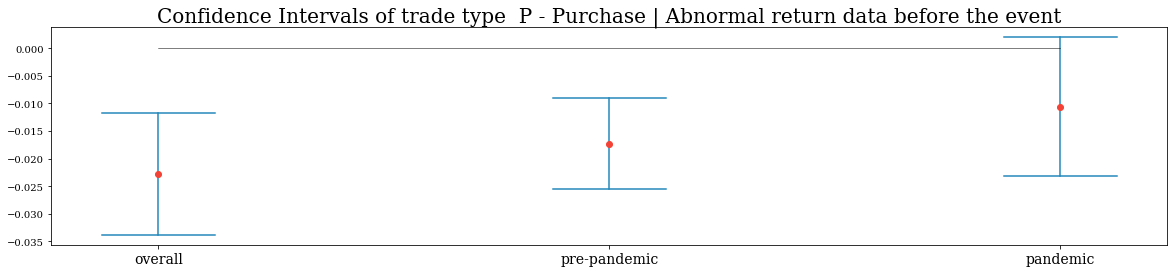

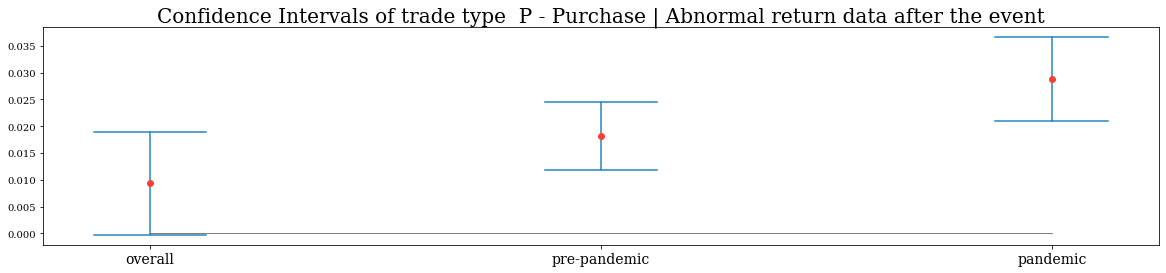

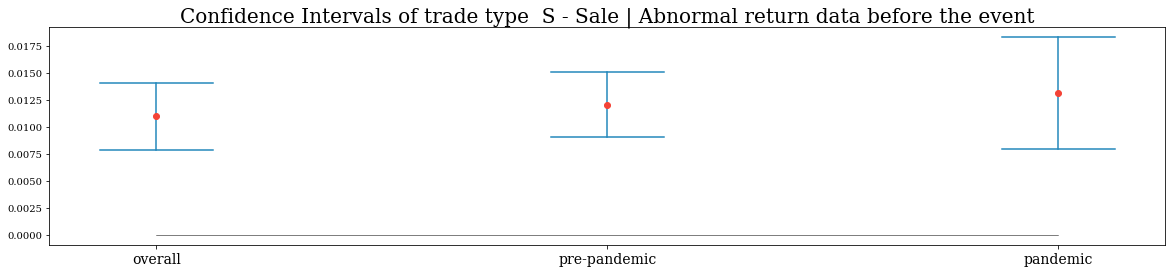

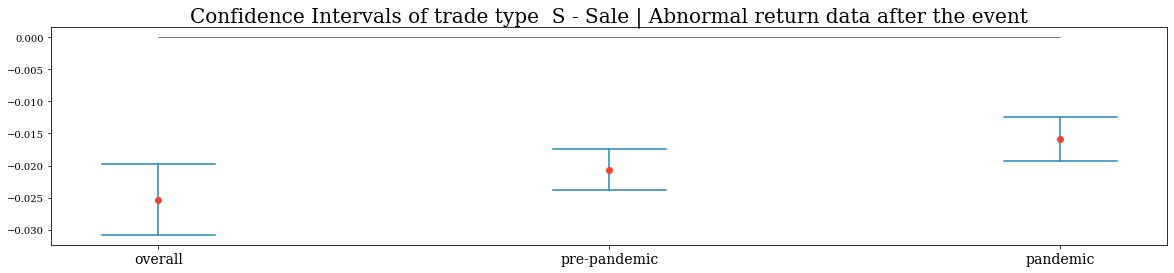

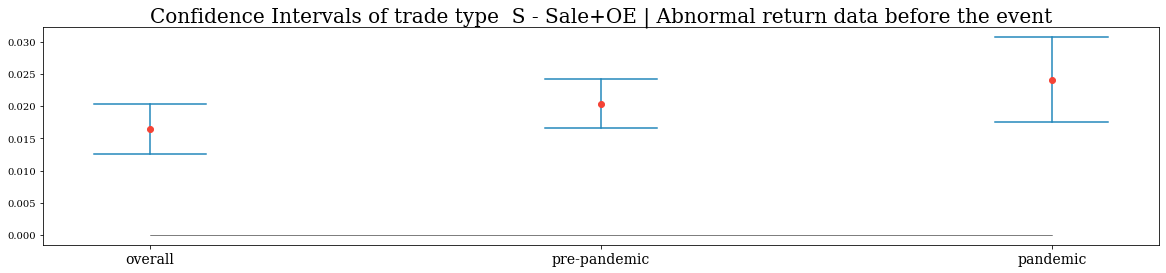

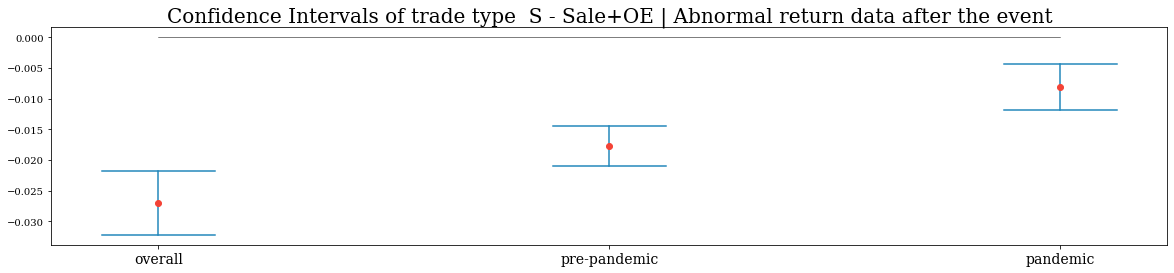

In [133]:
# purcase, sale and sale with oe
for t in types_of_interest:
    for side in event_day_ranges.keys():

        df_ = df_p.loc[t,:,side]

        def plot_confidence_interval(x, mean, CI, color='#2187bb', horizontal_line_width=0.25):


            left = x - horizontal_line_width / 2
            top = mean - CI
            right = x + horizontal_line_width / 2
            bottom = mean + CI
            plt.plot([x, x], [top, bottom], color=color)
            plt.plot([left, right], [top, top], color=color)
            plt.plot([left, right], [bottom, bottom], color=color)
            plt.plot(x, mean, 'o', color='#f44336')

            return mean, CI

        plt.figure(figsize=(20,4))

        df_to_plot = df_
        for i, row in enumerate(df_to_plot.sort_values("mean").itertuples()):
            mean, CI = plot_confidence_interval(i, row[1], row[6][1] - row[1])

        plt.plot(np.zeros(len(df_to_plot)), color="black", linewidth=0.5)
        plt.xticks(range(len(df_to_plot)), df_to_plot.index, fontsize=14)

        if side == "before":
            side_desc = "before the event"
        else:
            side_desc = "after the event"

        plt.title(f'Confidence Intervals of trade type  {t} | Abnormal return data {side_desc}', fontsize=20)
        plt.show()

In [128]:
types_of_interest

['P - Purchase', 'S - Sale', 'S - Sale+OE']

mean     ttest    median  Wilcoxon    N  \
Period       Side                                                  
overall      before  0.031179  0.011121  0.053748  0.000127  150   
             after   0.061339  0.000025  0.039327  0.000017  150   
pre-pandemic before  0.015408  0.373320  0.053748  0.006118   91   
             after   0.030818  0.086528  0.022705  0.121390   91   
pandemic     before  0.055504  0.000603  0.102356  0.001943   59   
             after   0.108414  0.000007  0.128113  0.000005   59   

                                95% CI  
Period       Side                       
overall      before   (0.0072, 0.0551)  
             after    (0.0335, 0.0892)  
pre-pandemic before  (-0.0188, 0.0496)  
             after   (-0.0045, 0.0661)  
pandemic     before   (0.0249, 0.0861)  
             after    (0.0646, 0.1522)

In [10]:
# This date will be moved to a loop
## Define which periods we are looking at.

if NAME == "Knudsen":
    event_index = 60
elif NAME == "Niedermayer":
    event_index = -200
else:
    raise NotImplementedError
    
event_timestamp = insider_data_df.FilingDate.iloc[event_index].floor("d") 
print("event timestamp: ", event_timestamp)

event timestamp:  2020-04-29 00:00:00


### Technical Checks

In [11]:
data_checks.run(L1_length, L2_length, event_timestamp, company_return)#, market_timeseries)

In [12]:
#company_return

### Determine T0, T1 and T2

In [13]:
T0_, T1_, T2_, T0, T1, T2, ERROR, msg = determine_T0_T1_T2.run(L1_length, L2_length, event_timestamp, company_return)#, market_timeseries)

DEBUG:root:Found T1 to be 2020-03-31 00:00:00 on index 1014
DEBUG:root:Found T2 to be 2020-05-28 00:00:00 on index 1054
DEBUG:root:Found T0 to be 2019-11-05 00:00:00 on index 914
DEBUG:root:------------------------------
DEBUG:root:Event occurred at             2020-04-29 00:00:00
DEBUG:root:Estimation Window (100 days): from 2019-11-05 00:00:00 to 2020-03-31 00:00:00
DEBUG:root:Event Window      ( 40 days): from 2020-03-31 00:00:00 to 2020-05-28 00:00:00


In [14]:
print(event_timestamp)
company_return

2020-04-29 00:00:00


,ReturnIndex,company_return,market_return
Date,,,
2016-03-21,1600.21,NaN,NaN
2016-03-22,1580.92,-0.012055,0.002660
2016-03-23,1560.78,-0.012739,-0.010951
2016-03-24,1559.94,-0.000538,0.000973
2016-03-28,1571.69,0.007532,-0.001406
...,...,...,...
2022-03-10,2844.15,0.008067,-0.009475
2022-03-11,2846.27,0.000745,-0.021794
2022-03-14,2853.15,0.002417,-0.020445


### Abnormal and Normal Returns

![alt text](assets/images/return_estimation.png "Title")

### Cut return timeseries into correct periods

In [15]:
windows = cut_timeseries.run(company_return, T0, T1, T2)
estimation_window_market_return, estimation_window_company_return, event_window_market_return, event_window_company_return = windows

DEBUG:root:shapes (Shouldnt be an issue after better preprocessing)
DEBUG:root:# estimation_window_market_return: (100,)
DEBUG:root:# estimation_window_market_return: (100,)
DEBUG:root:# event_window_market_return: (41,)
DEBUG:root:# event_window_company_return: (41,)


### Calculate coefficients

In [16]:
alpha, beta = calculate_coefficients.run(estimation_window_market_return, estimation_window_company_return)

DEBUG:root:                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     206.8
Date:                Mon, 19 Sep 2022   Prob (F-statistic):           6.98e-26
Time:                        11:53:21   Log-Likelihood:                 240.79
No. Observations:                 100   AIC:                            -477.6
Df Residuals:                      98   BIC:                            -472.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.002     -0.9

### The Abnormal Return
This is the last step of the whole process for one event

In [17]:
company_return = event_window_company_return
market_return = event_window_market_return
estimated_return = alpha + beta*market_return
abnormal_return = company_return - estimated_return
print(abnormal_return)

Date
2020-03-31    0.015095
2020-04-01   -0.008444
2020-04-02    0.007544
2020-04-03   -0.050434
2020-04-06   -0.037295
2020-04-07    0.006125
2020-04-08    0.019801
2020-04-09    0.077634
2020-04-13   -0.078287
2020-04-14   -0.043934
2020-04-15   -0.043138
2020-04-16   -0.063128
2020-04-17    0.023769
2020-04-20   -0.013170
2020-04-21    0.041644
2020-04-22   -0.044692
2020-04-23    0.011892
2020-04-24   -0.000497
2020-04-27    0.019721
2020-04-28    0.062805
2020-04-29   -0.000759
2020-04-30   -0.037613
2020-05-01    0.000250
2020-05-04   -0.015751
2020-05-05   -0.053100
2020-05-06   -0.023060
2020-05-07   -0.011147
2020-05-08    0.016750
2020-05-11   -0.046926
2020-05-12   -0.034776
2020-05-13   -0.014275
2020-05-14   -0.011064
2020-05-15   -0.019272
2020-05-18    0.035737
2020-05-19   -0.026781
2020-05-20    0.028348
2020-05-21    0.005152
2020-05-22    0.000581
2020-05-26    0.061268
2020-05-27    0.053070
2020-05-28   -0.014625
dtype: float64


<AxesSubplot:xlabel='Date'>

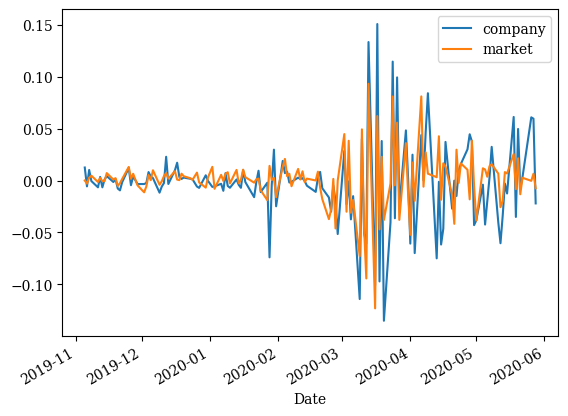

In [18]:
company_and_estimated = pd.DataFrame({"company":event_window_company_return, "market":estimated_return})
company_and_market = pd.DataFrame({"company": estimation_window_company_return, "market":estimation_window_market_return})
df_to_plot = pd.concat([company_and_market, company_and_estimated])
df_to_plot.plot()

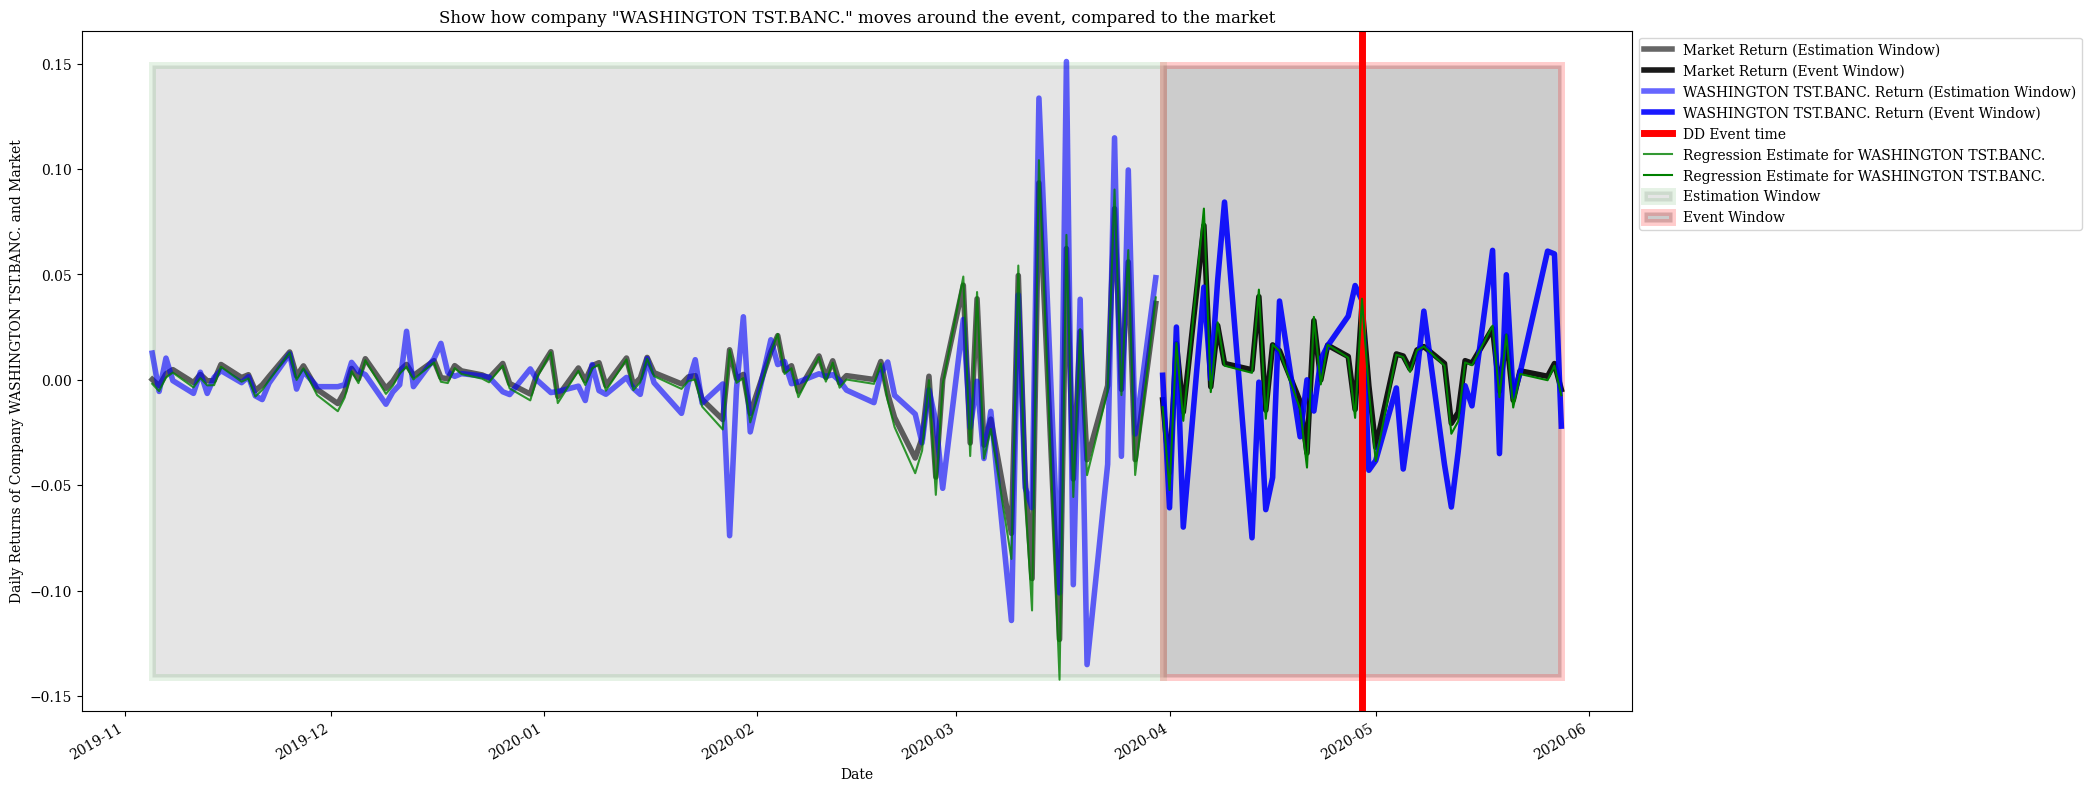

I'm impressed! It looks like a five-year-old drew this plot in paint


In [19]:
Company_name = company.name

# Estimations
est_estimation = estimation_window_market_return * beta + alpha
est_event = event_window_market_return * beta + alpha

plt.figure(figsize=(20,10))
estimation_window_market_return.plot(color = 'black', alpha = 0.6, linewidth=4, label = 'Market Return (Estimation Window)')
event_window_market_return.plot(color = 'black', alpha = 0.9, linewidth=4, label = 'Market Return (Event Window)')

estimation_window_company_return.plot(color = 'blue', alpha = 0.6, linewidth = 4, label = f'{Company_name} Return (Estimation Window)')
event_window_company_return.plot(color = 'blue', alpha = 0.9, linewidth = 4, label = f'{Company_name} Return (Event Window)')

plt.axvline(x = event_timestamp, color = 'red', label = 'DD Event time', linewidth = 5)
plt.ylabel(f'Daily Returns of Company {Company_name} and Market')
est_estimation.plot(color = 'green', label = f'Regression Estimate for {Company_name}', alpha = 0.8)
est_event.plot(color = 'green', label = f'Regression Estimate for {Company_name}', alpha = 1)

plt.axvspan(T0, T1, ymin = 0.05, ymax = 0.95, facecolor='black', alpha=0.1, label = 'Estimation Window', edgecolor='g', linewidth=5)
plt.axvspan(T1, T2, ymin = 0.05, ymax = 0.95, facecolor='black', alpha=0.2, label = 'Event Window', edgecolor='r', linewidth=5)
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')

plt.title(f'Show how company "{Company_name}" moves around the event, compared to the market')
plt.show()
print("I'm impressed! It looks like a five-year-old drew this plot in paint")


In [20]:
EVENT_INDEX = 20 # because right now 20 [0,..19] are before the event

## Macro Analysis

### Now that we have seen the process for one single filing, let us do the same for all filings in all companies


In [21]:
# Initialize testing
logging.getLogger().setLevel(logging.ERROR)

# Helpers
multiind, data, data_errors = [], [], []
n_companies = len(companies)

# this is the interval where filings are interesting to us
earliest_timestamp = pd.Timestamp("2018-01-01")
latest_timestamp = pd.Timestamp("2021-12-31")

#for j in tqdm(range(len(companies[:200]))):
for j in tqdm(range(len(companies))):
    # Get information from said company
    company = companies[j]
    company_return = company.return_index_df
    
    # Read in insider trading informations:
    filename = _insider_location + company.ticker + '.csv'
    filename = filename.replace(" ", "+") # HBB+WI in files and HBB WI as Ticker in base Excel, TODO should be fixed in base data
    insider_data_df = pd.read_csv(filename, index_col=0, parse_dates=['FilingDate', 'TradeDate'])
    
    
    n_filings = len(insider_data_df)
    # Go through all filings
    for i in insider_data_df.FilingDate.index:
        
        # Find our event date from filing
        filing_date = insider_data_df.FilingDate[i]
        event_timestamp = filing_date.floor("d")

        # if the timestamp is too early or too late we skip
        if event_timestamp < earliest_timestamp or event_timestamp > latest_timestamp:
            #print("skipping, filing is too early or too late")
            continue
            
        #print(f"working on company {j}/{n_companies} named {company.name}, filing {i}/{n_filings}")

        # do the process for one filing
        ## See if it's possible
        checks = data_checks.run(L1_length, L2_length, event_timestamp, company_return)
        if checks:
            #print(checks[1])
            data_errors.append(checks[0])
            continue
   
        ## Proceed to find periods
        T0_, T1_, T2_, T0, T1, T2, ERRORS, msg = determine_T0_T1_T2.run(L1_length, L2_length, event_timestamp, company_return)#, market_timeseries)
        if ERRORS:
            #print(msg)
            data_errors.append(ERRORS)
            continue
            
        ## Cut timeseries to the relevant periods, and split them
        windows = cut_timeseries.run(company_return, T0, T1, T2)
        estimation_window_market_return, estimation_window_company_return, event_window_market_return, event_window_company_return = windows
        alpha, beta = calculate_coefficients.run(estimation_window_market_return, estimation_window_company_return)

        ## Calculate the abnormal returns
        abnormal_return = event_window_company_return - alpha - beta*event_window_market_return
        
        ## Append to results set
        multiind.append((company.ticker, i, insider_data_df.TradeType[i], event_timestamp))
        data.append(abnormal_return)

 52%|█████▏    | 1514/2886 [12:24<09:22,  2.44it/s]  C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\statsmodels\regression\linear_model.py:1825: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\statsmodels\stats\stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
C:\Users\waxfa\.conda\envs\intDisp\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: inval

In [22]:
# process abnormal returns
df_abnormal_returns = pd.DataFrame.from_records([d.reset_index(drop=True) for d in data])
df_abnormal_returns.index = pd.MultiIndex.from_tuples(multiind, names=["Company", "i", "TradeType", "event_timestamp"])
df_abnormal_returns

0         1         2   \
Company i  TradeType           event_timestamp                                 
IMTE    0  S - Sale            2021-10-05       0.012126  0.021317  0.002348   
        1  S - Sale            2021-10-05       0.012126  0.021317  0.002348   
        2  A - Grant           2020-10-20       0.015693 -0.048428  0.044395   
        3  M - OptEx           2020-10-20       0.015693 -0.048428  0.044395   
ACGL    14 F - Tax             2021-11-18       0.002250  0.012087 -0.002870   
...                                                  ...       ...       ...   
NESR    2  A - Grant           2018-06-08      -0.000215  0.000433 -0.002691   
        3  C - Converted deriv 2018-06-08      -0.000215  0.000433 -0.002691   
        4  P - Purchase        2018-05-15       0.001948  0.003880 -0.005122   
SJ      0  C - Converted deriv 2020-05-11       0.000677 -0.000736 -0.000012   
        1  P - Purchase        2020-01-17      -0.000077  0.000088 -0.000945   

                                                      3         4         5   \
Company i  TradeType           event_timestamp                                 
IMTE    0  S - Sale            2021-10-05       0.056889  0.020259 -0.106961   
        1  S - Sale            2021-10-05       0.056889  0.020259 -0.106961   
        2  A - Grant           2020-10-20      -0.025923 -0.037550 -0.035355   
        3  M - OptEx           2020-10-20      -0.025923 -0.037550 -0.035355   
ACGL    14 F - Tax             2021-11-18      -0.004898 -0.019147 -0.015832   
...                                                  ...       ...       ...   
NESR    2  A - Grant           2018-06-08      -0.000063  0.000848  0.005834   
        3  C - Converted deriv 2018-06-08      -0.000063  0.000848  0.005834   
        4  P - Purchase        2018-05-15       0.001847 -0.002094 -0.001104   
SJ      0  C - Converted deriv 2020-05-11      -0.001374 -0.000391  0.005709   
        1  P - Purchase        2020-01-17      -0.000029 -0.000069  0.002146   

                                                      6         7         8   \
Company i  TradeType           event_timestamp                                 
IMTE    0  S - Sale            2021-10-05      -0.014988 -0.011138  0.029817   
        1  S - Sale            2021-10-05      -0.014988 -0.011138  0.029817   
        2  A - Grant           2020-10-20       0.030909 -0.027829  0.031959   
        3  M - OptEx           2020-10-20       0.030909 -0.027829  0.031959   
ACGL    14 F - Tax             2021-11-18      -0.007438  0.013804  0.011532   
...                                                  ...       ...       ...   
NESR    2  A - Grant           2018-06-08      -0.000101  0.002727 -0.007979   
        3  C - Converted deriv 2018-06-08      -0.000101  0.002727 -0.007979   
        4  P - Purchase        2018-05-15       0.000846 -0.000047  0.004920   
SJ      0  C - Converted deriv 2020-05-11      -0.005951  0.000743 -0.000772   
        1  P - Purchase        2020-01-17      -0.000137 -0.000268 -0.000012   

                                                      9   ...        31  \
Company i  TradeType           event_timestamp            ...             
IMTE    0  S - Sale            2021-10-05       0.039381  ...  0.005358   
        1  S - Sale            2021-10-05       0.039381  ...  0.005358   
        2  A - Grant           2020-10-20      -0.010526  ... -0.017747   
        3  M - OptEx           2020-10-20      -0.010526  ... -0.017747   
ACGL    14 F - Tax             2021-11-18      -0.004619  ...  0.015053   
...                                                  ...  ...       ...   
NESR    2  A - Grant           2018-06-08      -0.003118  ... -0.000935   
        3  C - Converted deriv 2018-06-08      -0.003118  ... -0.000935   
        4  P - Purchase        2018-05-15      -0.003141  ... -0.000109   
SJ      0  C - Converted deriv 2020-05-11       0.009891  ...  0.037883   
        1  P - Purchase        

### Show the reasons filings were dropped

<AxesSubplot:>

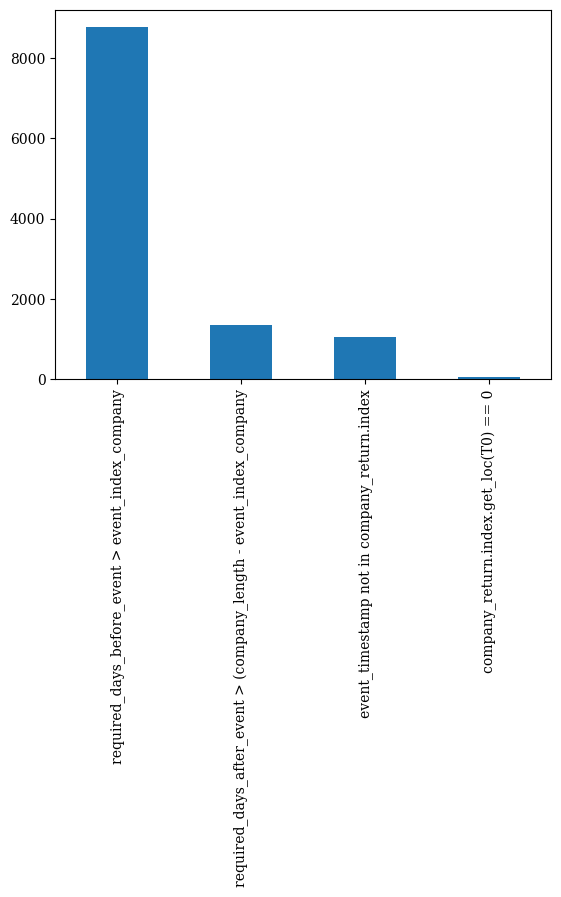

In [23]:
errors_df = pd.DataFrame.from_records(data_errors)
errors_df.sum(axis=0).plot.bar()

### Having a look at all trade types together

In [24]:
df_abnormal_returns.loc[:,:,["P - Purchase", "S - Sale", "S - Sale+OE"],:]

0         1         2   \
Company i   TradeType    event_timestamp                                 
ACGL    23  P - Purchase 2021-11-12      -0.011237 -0.008574 -0.011561   
        78  P - Purchase 2020-05-20      -0.046837 -0.021745 -0.042353   
        81  P - Purchase 2020-05-15       0.011601  0.000333 -0.005330   
        94  P - Purchase 2020-05-08       0.073148 -0.060993 -0.046641   
        179 P - Purchase 2018-11-29       0.017040  0.003109 -0.018433   
...                                            ...       ...       ...   
ESTA    10  S - Sale+OE  2021-08-09      -0.043853 -0.001680 -0.067295   
        12  S - Sale+OE  2021-06-11      -0.005784  0.025749 -0.011808   
        15  S - Sale+OE  2021-05-21       0.010573 -0.011018  0.010731   
        19  S - Sale+OE  2021-05-20       0.007037  0.010460 -0.011093   
GTEC    14  S - Sale+OE  2019-11-08      -0.014461 -0.096362 -0.055544   

                                                3         4         5   \
Company i   TradeType    event_timestamp                                 
ACGL    23  P - Purchase 2021-11-12       0.013640  0.001997  0.012204   
        78  P - Purchase 2020-05-20       0.032686  0.025542 -0.007387   
        81  P - Purchase 2020-05-15      -0.046623 -0.021645 -0.042186   
        94  P - Purchase 2020-05-08      -0.044189 -0.050032  0.009853   
        179 P - Purchase 2018-11-29      -0.005547 -0.001299 -0.002184   
...                                            ...       ...       ...   
ESTA    10  S - Sale+OE  2021-08-09       0.031456 -0.013298 -0.016498   
        12  S - Sale+OE  2021-06-11       0.043351  0.020864 -0.020792   
        15  S - Sale+OE  2021-05-21      -0.057160  0.009252 -0.016823   
        19  S - Sale+OE  2021-05-20       0.010737 -0.057158  0.009220   
GTEC    14  S - Sale+OE  2019-11-08      -0.134607 -0.073147  0.479799   

                                                6         7         8   \
Company i   TradeType    event_timestamp                                 
ACGL    23  P - Purchase 2021-11-12      -0.003195 -0.005008 -0.019241   
        78  P - Purchase 2020-05-20      -0.053184  0.005794  0.018287   
        81  P - Purchase 2020-05-15       0.032831  0.025586 -0.007143   
        94  P - Purchase 2020-05-08      -0.000962 -0.006165 -0.048641   
        179 P - Purchase 2018-11-29       0.008996  0.007363  0.000558   
...                                            ...       ...       ...   
ESTA    10  S - Sale+OE  2021-08-09      -0.017082  0.030108 -0.011624   
        12  S - Sale+OE  2021-06-11       0.004179  0.008488  0.005585   
        15  S - Sale+OE  2021-05-21      -0.051353  0.004831  0.018770   
        19  S - Sale+OE  2021-05-20      -0.016783 -0.051337  0.004940   
GTEC    14  S - Sale+OE  2019-11-08       0.001712 -0.211728  0.004824   

                                                9   ...        31        32  \
Company i   TradeType    event_timestamp            ...                       
ACGL    23  P - Purchase 2021-11-12      -0.016283  ... -0.022326  0.020497   
        78  P - Purchase 2020-05-20      -0.012839  ...  0.044768  0.008856   
        81  P - Purchase 2020-05-15      -0.053095  ...  0.040572  0.059108   
        94  P - Purchase 2020-05-08      -0.023132  ...  0.038687  0.010874   
        179 P - Purchase 2018-11-29       0.004839  ... -0.006537  0.012192   
...                                            ...  ...       ...       ...   
ESTA    10  S - Sale+OE  2021-08-09      -0.004272  ... -0.029820 -0.008953   
        12  S - Sale+OE  2021-06-11      -0.029965  ... -0.019196  0.014319   
        15  S - Sale+OE  2021-05-21      -0.043795  ...  0.027545 -0.027151   
        19  S - Sale+OE  2021-05-20       0.018778  ... -0.008649  0.027507   
GTEC    14  S - Sale+OE  2019-11-08       0.097381  ...  0.002034 -0.050608   

                                                33        34        35  \
Company i   TradeType    event_timestamp                 

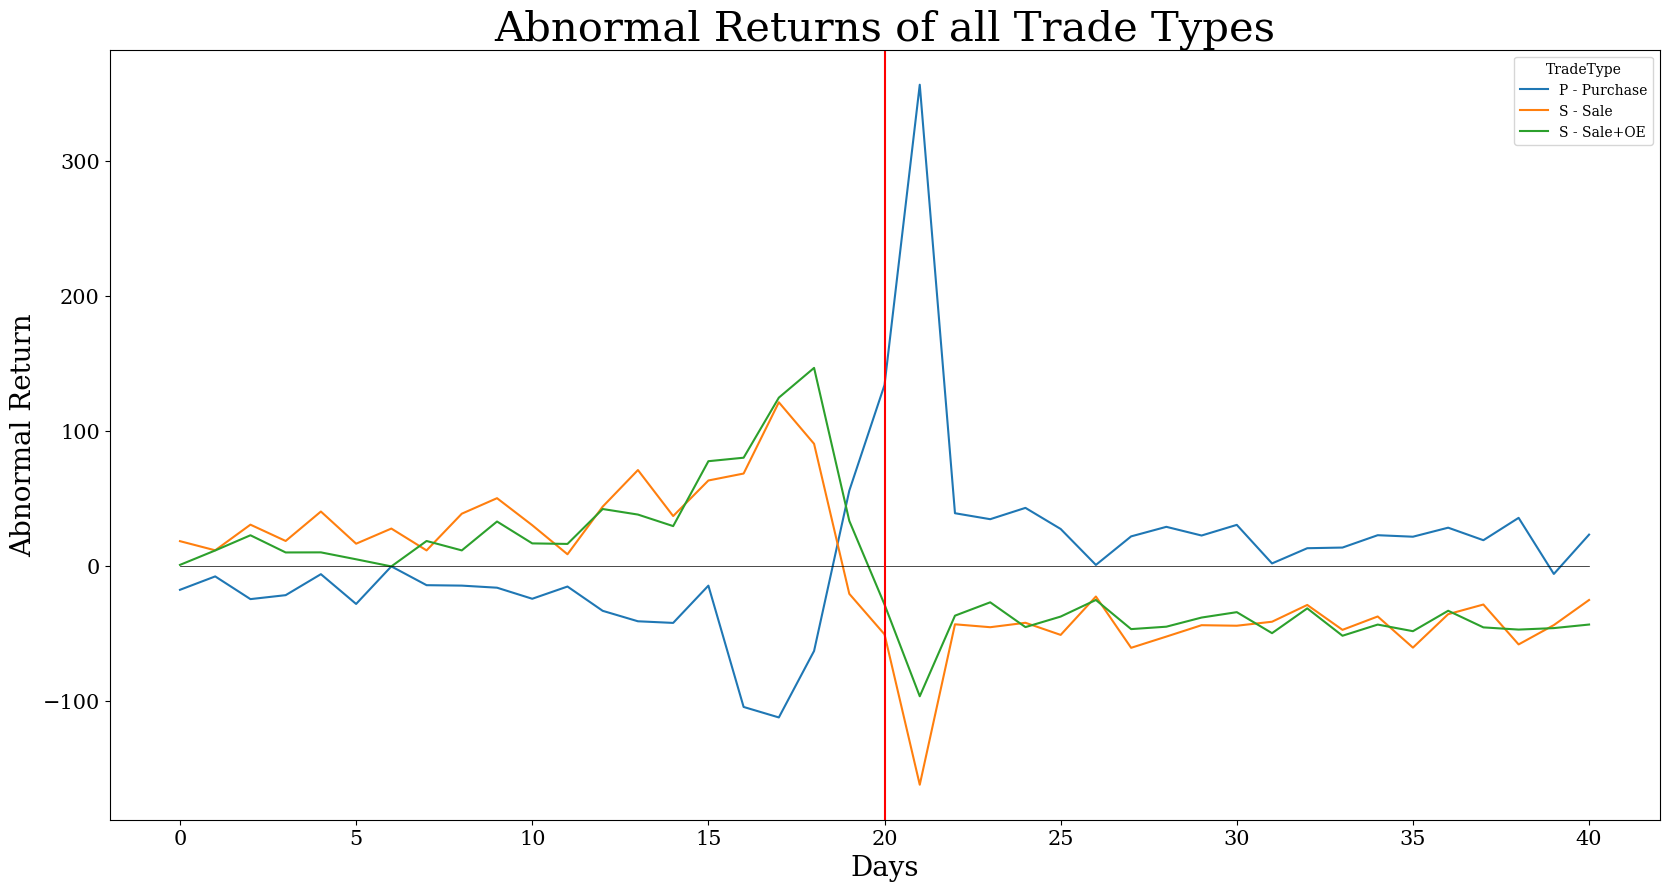

In [45]:

a = df_abnormal_returns.loc[:,:,["P - Purchase", "S - Sale", "S - Sale+OE"],:].groupby(level=[2]).sum().transpose().plot(figsize=(20, 10), fontsize=15)
plt.plot(np.zeros(len(df_abnormal_returns.columns)), color="black", linewidth=0.5)
a.set_title("Abnormal Returns of all Trade Types",fontsize=30)
a.set_xlabel("Days", fontsize=20)
a.set_ylabel("Abnormal Return", fontsize=20)
plt.axvline(x = EVENT_INDEX, color = 'red', label = 'DD Event time', linewidth = 1.5)
plt.savefig(f"data/{NAME}/visualisations/AR_selected_tradetypes.png", dpi=600)

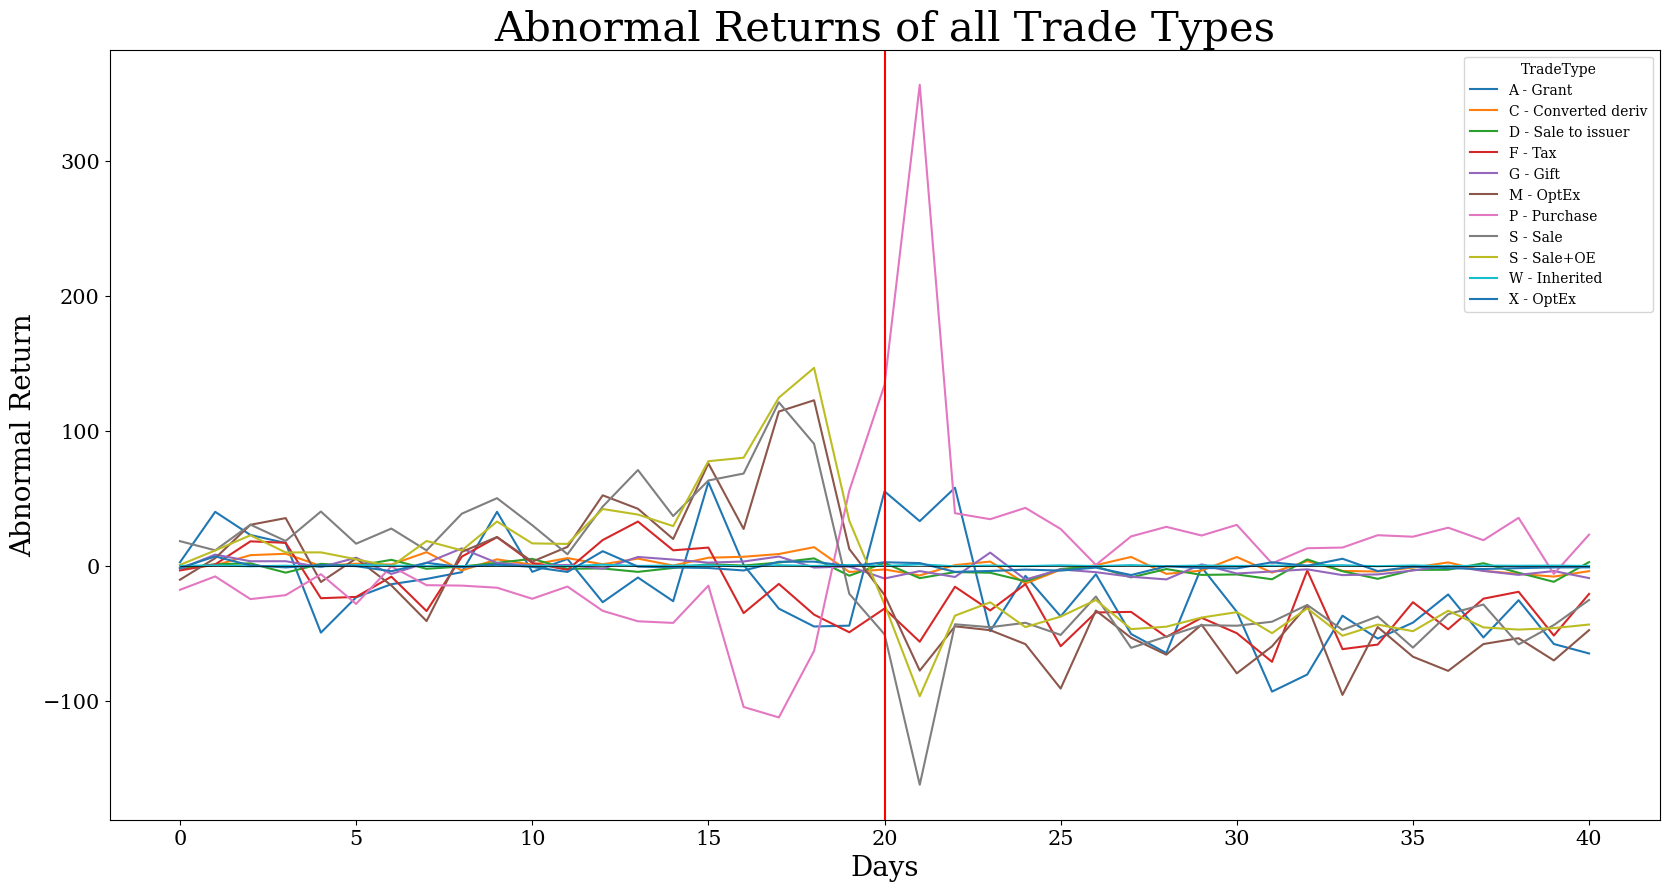

In [46]:
a = df_abnormal_returns.groupby(level=[2]).sum().transpose().plot(figsize=(20, 10), fontsize=15)
plt.plot(np.zeros(len(df_abnormal_returns.columns)), color="black", linewidth=0.5)
a.set_title("Abnormal Returns of all Trade Types",fontsize=30)
a.set_xlabel("Days", fontsize=20)
a.set_ylabel("Abnormal Return", fontsize=20)
plt.axvline(x = EVENT_INDEX, color = 'red', label = 'DD Event time', linewidth = 1.5)
plt.savefig(f"data/{NAME}/visualisations/AR_all_tradetypes.png", dpi=600)

In [27]:
df_abnormal_returns

0         1         2   \
Company i  TradeType           event_timestamp                                 
IMTE    0  S - Sale            2021-10-05       0.012126  0.021317  0.002348   
        1  S - Sale            2021-10-05       0.012126  0.021317  0.002348   
        2  A - Grant           2020-10-20       0.015693 -0.048428  0.044395   
        3  M - OptEx           2020-10-20       0.015693 -0.048428  0.044395   
ACGL    14 F - Tax             2021-11-18       0.002250  0.012087 -0.002870   
...                                                  ...       ...       ...   
NESR    2  A - Grant           2018-06-08      -0.000215  0.000433 -0.002691   
        3  C - Converted deriv 2018-06-08      -0.000215  0.000433 -0.002691   
        4  P - Purchase        2018-05-15       0.001948  0.003880 -0.005122   
SJ      0  C - Converted deriv 2020-05-11       0.000677 -0.000736 -0.000012   
        1  P - Purchase        2020-01-17      -0.000077  0.000088 -0.000945   

                                                      3         4         5   \
Company i  TradeType           event_timestamp                                 
IMTE    0  S - Sale            2021-10-05       0.056889  0.020259 -0.106961   
        1  S - Sale            2021-10-05       0.056889  0.020259 -0.106961   
        2  A - Grant           2020-10-20      -0.025923 -0.037550 -0.035355   
        3  M - OptEx           2020-10-20      -0.025923 -0.037550 -0.035355   
ACGL    14 F - Tax             2021-11-18      -0.004898 -0.019147 -0.015832   
...                                                  ...       ...       ...   
NESR    2  A - Grant           2018-06-08      -0.000063  0.000848  0.005834   
        3  C - Converted deriv 2018-06-08      -0.000063  0.000848  0.005834   
        4  P - Purchase        2018-05-15       0.001847 -0.002094 -0.001104   
SJ      0  C - Converted deriv 2020-05-11      -0.001374 -0.000391  0.005709   
        1  P - Purchase        2020-01-17      -0.000029 -0.000069  0.002146   

                                                      6         7         8   \
Company i  TradeType           event_timestamp                                 
IMTE    0  S - Sale            2021-10-05      -0.014988 -0.011138  0.029817   
        1  S - Sale            2021-10-05      -0.014988 -0.011138  0.029817   
        2  A - Grant           2020-10-20       0.030909 -0.027829  0.031959   
        3  M - OptEx           2020-10-20       0.030909 -0.027829  0.031959   
ACGL    14 F - Tax             2021-11-18      -0.007438  0.013804  0.011532   
...                                                  ...       ...       ...   
NESR    2  A - Grant           2018-06-08      -0.000101  0.002727 -0.007979   
        3  C - Converted deriv 2018-06-08      -0.000101  0.002727 -0.007979   
        4  P - Purchase        2018-05-15       0.000846 -0.000047  0.004920   
SJ      0  C - Converted deriv 2020-05-11      -0.005951  0.000743 -0.000772   
        1  P - Purchase        2020-01-17      -0.000137 -0.000268 -0.000012   

                                                      9   ...        31  \
Company i  TradeType           event_timestamp            ...             
IMTE    0  S - Sale            2021-10-05       0.039381  ...  0.005358   
        1  S - Sale            2021-10-05       0.039381  ...  0.005358   
        2  A - Grant           2020-10-20      -0.010526  ... -0.017747   
        3  M - OptEx           2020-10-20      -0.010526  ... -0.017747   
ACGL    14 F - Tax             2021-11-18      -0.004619  ...  0.015053   
...                                                  ...  ...       ...   
NESR    2  A - Grant           2018-06-08      -0.003118  ... -0.000935   
        3  C - Converted deriv 2018-06-08      -0.003118  ... -0.000935   
        4  P - Purchase        2018-05-15      -0.003141  ... -0.000109   
SJ      0  C - Converted deriv 2020-05-11       0.009891  ...  0.037883   
        1  P - Purchase        

I think OE and OptEx means option exercise. "to exercise" means to put into effect the right to buy or sell the underlying security that is specified in the options contract." Can we be sure that the action does not shift the market, and the swing in return is really due to new information? Are these trades public, so maybe they are used as a signal for traders?

### Boxplot of the sum over all companies's AR

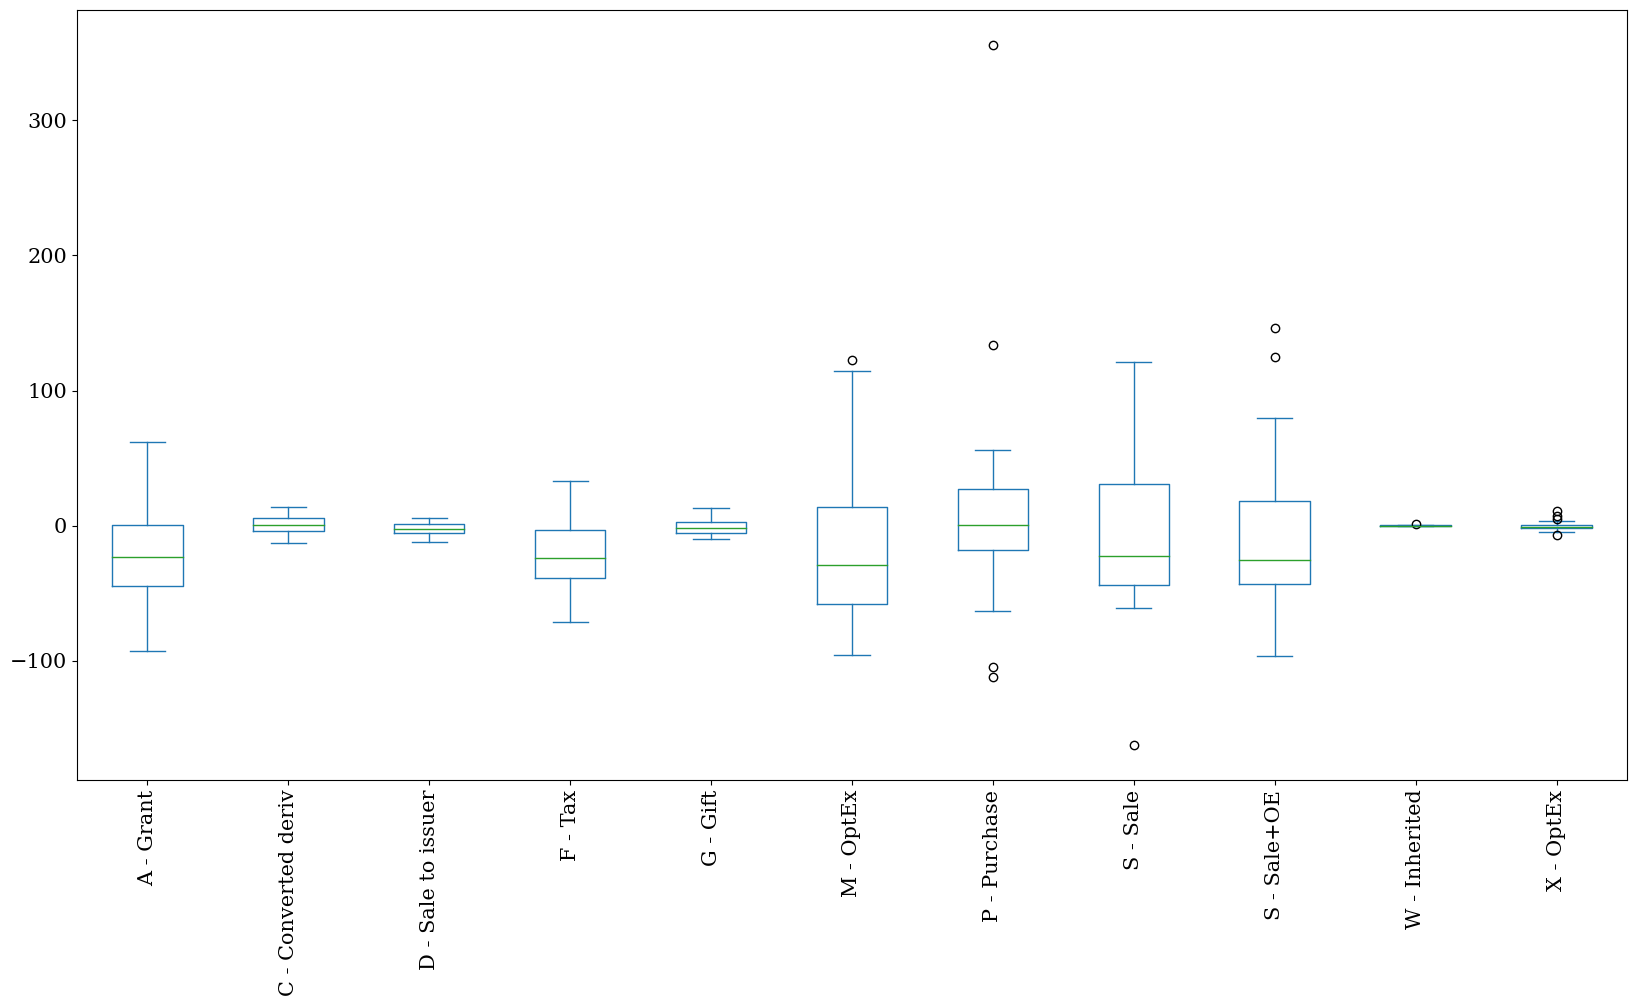

In [28]:
df_abnormal_returns.groupby(level=[2]).sum().transpose().plot.box(rot=90, figsize=(20, 10), fontsize=15)
ax.set_title("Boxplots of the Abnormal Returns for each Trade Type",fontsize=30)
ax.set_xlabel("Trade Type", fontsize=20)
ax.set_ylabel("Abnormal Return", fontsize=20)

plt.savefig(f"data/{NAME}/visualisations/AR_all_tradetypes_boxplot.png", dpi=600)

![alt text](assets/images/time_agg.png)

In our case it is not company i, but filing i

Types of trade to pick from:

In [29]:
types = list(set([x[2] for x in df_abnormal_returns.index]))
types

['S - Sale',
 'M - OptEx',
 'S - Sale+OE',
 'C - Converted deriv',
 'A - Grant',
 'X - OptEx',
 'F - Tax',
 'W - Inherited',
 'D - Sale to issuer',
 'P - Purchase',
 'G - Gift']

Specify the type of the trades to investigate

In [30]:
type_ = "P - Purchase" # "S - Sale"
df_abnormal_returns_type = df_abnormal_returns.loc[:,:,type_]

The index describes the company and the index of the filing in the compnay, the columns represent the days in the event window

In [31]:
df_abnormal_returns_type

0         1         2         3         4   \
Company i   event_timestamp                                                     
ACGL    23  2021-11-12      -0.011237 -0.008574 -0.011561  0.013640  0.001997   
        78  2020-05-20      -0.046837 -0.021745 -0.042353  0.032686  0.025542   
        81  2020-05-15       0.011601  0.000333 -0.005330 -0.046623 -0.021645   
        94  2020-05-08       0.073148 -0.060993 -0.046641 -0.044189 -0.050032   
        179 2018-11-29       0.017040  0.003109 -0.018433 -0.005547 -0.001299   
...                               ...       ...       ...       ...       ...   
HIHO    9   2019-05-14      -0.038622  0.013967 -0.005238  0.001271  0.014433   
NESR    0   2018-06-08      -0.000215  0.000433 -0.002691 -0.000063  0.000848   
        1   2018-06-08      -0.000215  0.000433 -0.002691 -0.000063  0.000848   
        4   2018-05-15       0.001948  0.003880 -0.005122  0.001847 -0.002094   
SJ      1   2020-01-17      -0.000077  0.000088 -0.000945 -0.000029 -0.000069   

                                   5         6         7         8         9   \
Company i   event_timestamp                                                     
ACGL    23  2021-11-12       0.012204 -0.003195 -0.005008 -0.019241 -0.016283   
        78  2020-05-20      -0.007387 -0.053184  0.005794  0.018287 -0.012839   
        81  2020-05-15      -0.042186  0.032831  0.025586 -0.007143 -0.053095   
        94  2020-05-08       0.009853 -0.000962 -0.006165 -0.048641 -0.023132   
        179 2018-11-29      -0.002184  0.008996  0.007363  0.000558  0.004839   
...                               ...       ...       ...       ...       ...   
HIHO    9   2019-05-14      -0.041043  0.005643  0.003408  0.001786  0.001539   
NESR    0   2018-06-08       0.005834 -0.000101  0.002727 -0.007979 -0.003118   
        1   2018-06-08       0.005834 -0.000101  0.002727 -0.007979 -0.003118   
        4   2018-05-15      -0.001104  0.000846 -0.000047  0.004920 -0.003141   
SJ      1   2020-01-17       0.002146 -0.000137 -0.000268 -0.000012  0.000262   

                             ...        31        32        33        34  \
Company i   event_timestamp  ...                                           
ACGL    23  2021-11-12       ... -0.022326  0.020497  0.032558  0.011523   
        78  2020-05-20       ...  0.044768  0.008856 -0.035420 -0.048748   
        81  2020-05-15       ...  0.040572  0.059108  0.026241  0.044951   
        94  2020-05-08       ...  0.038687  0.010874 -0.021076 -0.042151   
        179 2018-11-29       ... -0.006537  0.012192 -0.004442 -0.012006   
...                          ...       ...       ...       ...       ...   
HIHO    9   2019-05-14       ...  0.026396 -0.021861  0.037870 -0.021943   
NESR    0   2018-06-08       ... -0.000935 -0.009609 -0.011431  0.013288   
        1   2018-06-08       ... -0.000935 -0.009609 -0.011431  0.013288   
        4   2018-05-15       ... -0.000109  0.000976 -0.009960 -0.008938   
SJ      1   2020-01-17       ...  0.000464  0.000023  0.000086 -0.000233   

                                   35        36        37        38        39  \
Company i   event_timestamp                                                     
ACGL    23  2021-11-12       0.014721 -0.015167 -0.003748  0.012887 -0.005969   
        78  2020-05-20      -0.007916  0.001389 -0.003642 -0.008689 -0.014328   
        81  2020-05-15       0.009002 -0.035307 -0.048621 -0.008027  0.001530   
        94  2020-05-08       0.025338  0.038972  0.057473  0.024883  0.043074   
        179 2018-11-29       0.000009 -0.019412  0.018335  0.022009 -0.006167   
...                               ...       ...       ...       ...       ...   
HIHO    9   2019-05-14      -0.004788  0.002090  0.035934 -0.062604  0.004977   
NESR    0   2018-06-08      -0.014453  0.011374 -0.004327  0.015638 -0.000256   
        1   2018-06-08      -0.014453  0.011374 -0.004327  0.015638 -0.000256   
        4   2018-05-15       0.017402  0.006692

In [32]:
# TODO Infinity Values idk why, should check out why they are there upstream

In [33]:
mask = (-df_abnormal_returns_type == np.Inf) |(df_abnormal_returns_type == np.Inf)
print(mask.sum().sum())
df_abnormal_returns_type[mask] = 0

C:\Users\waxfa\AppData\Local\Temp\ipykernel_13216\711303784.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_abnormal_returns_type[mask] = 0
C:\Users\waxfa\AppData\Local\Temp\ipykernel_13216\711303784.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_abnormal_returns_type[mask] = 0


<AxesSubplot:xlabel='Company,i,event_timestamp'>

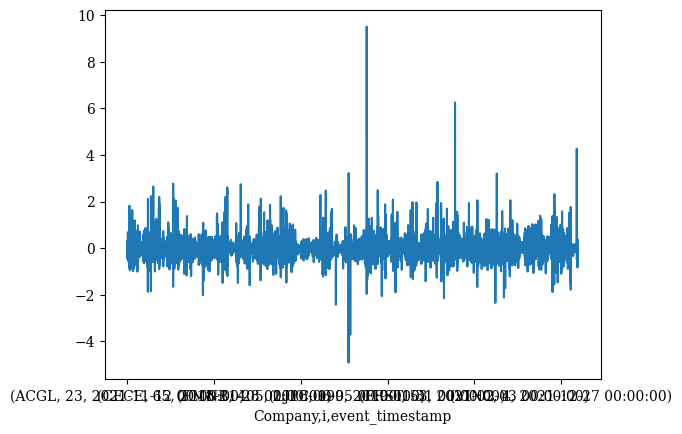

In [35]:
CAR = df_abnormal_returns_type.sum(axis=1)
CAR.plot()

![alt text](assets/images/cross_sectional_agg.png)


<AxesSubplot:>

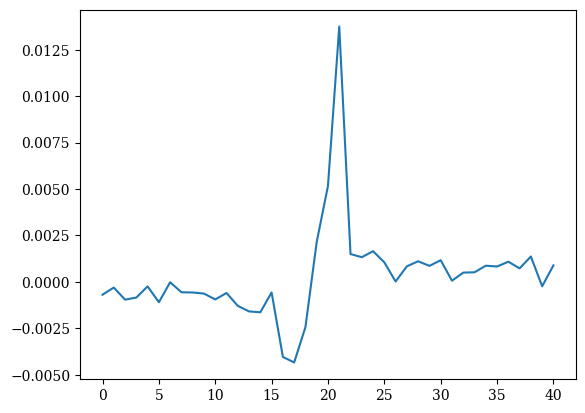

In [36]:
AR_bar = df_abnormal_returns_type.mean(axis=0) 
AR_bar.plot()

In [37]:
CAR_bar = AR_bar.sum()
CAR_bar

0.013885550795268061

In [38]:
# TODO var_CAR_bar = Does the definition make sense? It seems like we take the var of a scalar

![alt text](assets/images/cross_sectional_agg2.png)


In [39]:
CAR_bar_2 = CAR.mean()
CAR_bar_2

0.01384863732076995

In [40]:
# var car TODO not sure what just sigma means.

## Statistics

Check if CAR mean = 0 (t-test)

In [41]:
from scipy import stats

tt = stats.ttest_1samp(CAR, popmean=0)
tt

Ttest_1sampResult(statistic=6.628927250991535, pvalue=3.447588152936159e-11)

Check if CAR median = 0 (wilcoxon signed rank test)

In [42]:
stats.wilcoxon(CAR)

WilcoxonResult(statistic=166971310.0, pvalue=0.45180021194230957)

In [48]:
types = types
investigation_periods = {
    "overall": (pd.Timestamp("2018-01-01"), pd.Timestamp("2021-12-31")),
    "pre-pandemic": (pd.Timestamp("2018-01-01"), pd.Timestamp("2020-02-29")),
    "pandemic": (pd.Timestamp("2020-03-01"), pd.Timestamp("2021-12-31")),
}

multiind_p, data_p = [], []

event_day_ranges = {
    "before": (0,20), # TODO for now we drop the filing day itself
    "after": (21,41)
}


for type_ in types:
    for per in investigation_periods.keys():
        for side in event_day_ranges.keys():
                
            event_day_range = event_day_ranges[side]
            df_abnormal_returns_type = df_abnormal_returns.loc[:,:,type_]
            per_left,per_right = investigation_periods[per]


            timestamps = df_abnormal_returns_type.index.get_level_values(2)
            mask = (timestamps >= per_left) & (timestamps <= per_right)
            df_AR_type_per = df_abnormal_returns_type[mask]
            if not len(df_AR_type_per):
                print(f"skipping iteration because of 0 datapoints {(type_, per, side)}")
                continue
            df_AR_type_per_side = df_AR_type_per.iloc[:,event_day_range[0]:event_day_range[1]]
            CAR = df_AR_type_per_side.sum(axis=1)

            pvalue_ttest = round(stats.ttest_1samp(CAR, popmean=0).pvalue, 10)
            pvalue_wilcoxon = round(stats.wilcoxon(CAR).pvalue, 10)
            mean = CAR.mean()
            median = CAR.median()
            
            multiind_p.append((type_, per, side))
            data_p.append((mean, pvalue_ttest, median, pvalue_wilcoxon, len(df_AR_type_per)))

In [51]:
# process abnormal returns
df_p = pd.DataFrame.from_records(data_p)
df_p.index = pd.MultiIndex.from_tuples(multiind_p, names=["TradeType", "Period", "Side"])
df_p.columns = ["mean", "ttest pvalue", "median", "wilcoxon pvalue", "sample_size"]
df_p.to_csv(f"data/{NAME}/tests_result.csv")
df_p.sort_values("ttest pvalue")

mean  ttest pvalue    median  \
TradeType           Period       Side                                       
S - Sale            overall      before  0.015529      0.000000  0.009373   
F - Tax             pandemic     after  -0.008435      0.000000 -0.008523   
                    pre-pandemic after  -0.018372      0.000000 -0.010632   
P - Purchase        overall      before -0.021136      0.000000 -0.018639   
F - Tax             overall      after  -0.013877      0.000000 -0.009816   
...                                           ...           ...       ...   
A - Grant           pre-pandemic before -0.000191      0.773409 -0.001591   
W - Inherited       overall      after   0.002570      0.777909  0.002669   
                                 before -0.002282      0.803905 -0.010574   
C - Converted deriv pre-pandemic after   0.000487      0.902996 -0.012713   
W - Inherited       pandemic     before -0.000993      0.949648 -0.006631   

                                         wilcoxon pvalue  sample_size  
TradeType           Period       Side                                  
S - Sale            overall      before         0.000000        49836  
F - Tax             pandemic     after          0.000000        25225  
                    pre-pandemic after          0.000000        30541  
P - Purchase        overall      before         0.000000        25978  
F - Tax             overall      after          0.000000        55766  
...                                                  ...          ...  
A - Grant           pre-pandemic before         0.000005        46094  
W - Inherited       overall      after          0.746517          107  
                                 before         0.623377          107  
C - Converted deriv pre-pandemic after          0.055739         1869  
W - Inherited       pandemic     before         0.924710           49  

[66 rows x 5 columns]

#### Export information to latex

In [53]:
counter = 0
for t in types:
    counter = counter+1
    #print(t)
    df_ = df_p.loc[t,:,:]
    df_ = df_.rename(columns={'Side of the event': 'Side'
                              , 'mean': 'mean'
                              , 'ttest pvalue': 'ttest'
                              , 'median': 'median'
                              , 'wilcoxon pvalue': 'Wilcoxon'
                              , 'sample_size': 'N'})
    #display(df_)
    
    latex = df_\
    .to_latex( column_format="llrrrrr"
              , position="H"
              , label=f"table:t{counter}_hypothesistest"
              , caption= f"Hypothesis tests for type: {t}"
              #, index = False
    )
    print(latex)    

\begin{table}[H]
\centering
\caption{Hypothesis tests for type: S - Sale}
\label{table:t1_hypothesistest}
\begin{tabular}{llrrrrr}
\toprule
         &       &      mean &  ttest &    median &  Wilcoxon &      N \\
Period & Side &           &        &           &           &        \\
\midrule
overall & before &  0.015529 &    0.0 &  0.009373 &       0.0 &  49836 \\
         & after & -0.019624 &    0.0 & -0.016236 &       0.0 &  49836 \\
pre-pandemic & before &  0.016233 &    0.0 &  0.009433 &       0.0 &  23404 \\
         & after & -0.014454 &    0.0 & -0.013063 &       0.0 &  23404 \\
pandemic & before &  0.014905 &    0.0 &  0.009317 &       0.0 &  26432 \\
         & after & -0.024203 &    0.0 & -0.020355 &       0.0 &  26432 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[H]
\centering
\caption{Hypothesis tests for type: M - OptEx}
\label{table:t2_hypothesistest}
\begin{tabular}{llrrrrr}
\toprule
         &       &      mean &         ttest &    median &      Wilcoxon &  

C:\Users\waxfa\AppData\Local\Temp\ipykernel_13216\2908762223.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = df_\
C:\Users\waxfa\AppData\Local\Temp\ipykernel_13216\2908762223.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = df_\
C:\Users\waxfa\AppData\Local\Temp\ipykernel_13216\2908762223.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The